## CPA Hyperparameter Optimization with Optuna

CPA-Predicting perturbation responses for unseen cell-types (context transfer)

### Functions

In [1]:
import optuna

In [2]:
import cpa
from rdkit import Chem
import scanpy as sc
from pandas import CategoricalDtype
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.sparse import issparse
from optuna.samplers import GridSampler
import scipy.sparse as sparse
from scipy.spatial.distance import cdist


Global seed set to 0


### Loading the dataset, standardizing condition labels, and filtering out stimulated cells of a specific cell line to construct a clean training subset for CPA model training.

In [3]:
# loading the data directly from the file
adata = sc.read('./plate9_preprocessed_for_CPA_pred_cell_final.h5ad') 

# renaming the 'label' column to 'condition'
adata.obs.rename(columns={"label": "condition"}, inplace=True) 

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype): 
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )
    
# Creating a training set by excluding 'stimulated' cells of the specified cell type (CVCL_0546 in this case)
celltype_to_train = 'CVCL_0546' 

# Filtering the AnnData object to create a training set
train_adata = adata[~(                  
    (adata.obs['cell_line'] == celltype_to_train) &
    (adata.obs['condition'] == 'stimulated')
)].copy()

### Defining Search Space for Hyperparameter Optimization & Metrics - Running Optuna Optimization

In [4]:
SEED = 42
adata.obs["cell_type"] = adata.obs["cell_line"]        #on Tahoe dataset is being mentioned as cell line

#Setup CPA-specific keys---------------------------------------------------------------
cpa.CPA.setup_anndata(adata,
                          perturbation_key='condition',
                          control_group='control' ,                                    
                          dosage_key='log_dose',
                          categorical_covariate_keys=['cell_line'],)

# Choose which cell type to hold out
cell_line_holdout = 'CVCL_0546'

# Initialize all as train
adata.obs['split_CVCL_0546'] = 'train'

# Mark OOD on that cell type
adata.obs.loc[adata.obs['cell_line'] == cell_line_holdout, 'split_CVCL_0546'] = 'ood'

# Define Train / Valid / OOD Splits
train_idx = adata.obs.index[adata.obs['split_CVCL_0546'] == 'train']
n_val = max(1, int(0.05 * len(train_idx)))
val_idx = np.random.choice(train_idx, size=n_val, replace=False)
adata.obs.loc[val_idx, 'split_CVCL_0546'] = 'valid'

# Inspect counts
print(adata.obs['split_CVCL_0546'].value_counts())


# Define Search Space for Hyperparameter Optimization ------------------------------------
search_space = {
    "n_latent": [32, 128, 254],
    "n_hidden_encoder": [128, 512],
    "n_layers_encoder": [2, 3],
    "dropout_rate_encoder": [0.05, 0.1],
    "lr": [1e-4, 1e-3]     
}
sampler = GridSampler(search_space)    


# Define Evaluation Metrics---------------------------------------------------------------
def bootstrap_metrics(X, mask_true, mask_pred, X_pca=None, n_boot=10):
    # Mean expression across cells
    x_true = X[mask_true].mean(axis=0)
    x_pred = X[mask_pred].mean(axis=0)

    r2 = r2_score(x_true, x_pred)
    mse = mean_squared_error(x_true, x_pred)
    pearson = pearsonr(x_true, x_pred)[0]

    return {
        "R2": r2,
        "MSE": mse,
        "Pearson": pearson
    }

def energy_d(X1, X2):
    """
    Compute the energy distance between two distributions.
    X1, X2: numpy arrays (n_cells × n_features), e.g. PCA embeddings
    """
    d1 = cdist(X1, X1, metric='euclidean')
    d2 = cdist(X2, X2, metric='euclidean')
    d12 = cdist(X1, X2, metric='euclidean')

    return 2 * d12.mean() - d1.mean() - d2.mean()
def mean_var_kde_distance(X_ref, X_pred):
    """
    Simple distance based on mean and variance of expression profiles.
    """
    mean_diff = np.linalg.norm(X_ref.mean(axis=0) - X_pred.mean(axis=0))
    var_diff = np.linalg.norm(X_ref.var(axis=0) - X_pred.var(axis=0))
    return mean_diff + var_diff


# Define Optuna Objective Function -------------------------------------------------------
def objective(trial: optuna.trial.Trial) -> float:
    n_latent = trial.suggest_categorical("n_latent", search_space["n_latent"])
    n_hidden_encoder = trial.suggest_categorical("n_hidden_encoder", search_space["n_hidden_encoder"])
    n_layers_encoder = trial.suggest_categorical("n_layers_encoder", search_space["n_layers_encoder"])
    dropout_rate_encoder = trial.suggest_categorical("dropout_rate_encoder", search_space["dropout_rate_encoder"])
    lr = trial.suggest_categorical("lr", search_space["lr"])


    label = f"lat{n_latent}_enc{n_hidden_encoder}x{n_layers_encoder}_do{dropout_rate_encoder}_lr{lr}"
    print(f"\n🔧  Trial {trial.number:02d} – {label}")

    # (a) build training set (hide CVCL_0546 cells)
    train_adata = adata[~(
        (adata.obs["cell_line"] == "CVCL_0546") &
        (adata.obs["condition"] == "stimulated")
    )].copy()
    

    # Set-up + train ---------------------------------------------------------------------
    model_params = {
        "n_latent": n_latent,
        "recon_loss": "nb",
        "doser_type": "linear",
        "n_hidden_encoder": n_hidden_encoder,
        "n_layers_encoder": n_layers_encoder,
        "n_hidden_decoder": 128,
        "n_layers_decoder": 2,
        "use_batch_norm_encoder": True,
        "use_layer_norm_encoder": False,
        "use_batch_norm_decoder": False,
        "use_layer_norm_decoder": True,
        "dropout_rate_encoder": dropout_rate_encoder,
        "dropout_rate_decoder": 0.05,
        "variational": False,
        "seed": 6977,
    }

    trainer_params = {
        "n_epochs_kl_warmup": None,
        "n_epochs_pretrain_ae": 30,
        "n_epochs_adv_warmup": 50,
        "n_epochs_mixup_warmup": 0,
        "mixup_alpha": 0.0,
        "adv_steps": None,
        "n_hidden_adv": 64,
        "n_layers_adv": 3,
        "use_batch_norm_adv": True,
        "use_layer_norm_adv": False,
        "dropout_rate_adv": 0.3,
        "reg_adv": 20.0,
        "pen_adv": 5.0,
        "lr": lr,
        "wd": 4e-07,
        "adv_lr": 0.0003,
        "adv_wd": 4e-07,
        "adv_loss": "cce",
        "doser_lr": 0.0003,
        "doser_wd": 4e-07,
        "do_clip_grad": True,
        "gradient_clip_value": 1.0,
        "step_size_lr": 10,
    }

    model = cpa.CPA(
        adata                = adata,
        split_key            = "split_CVCL_0546",   
        train_split          = "train",
        valid_split          = "valid",
        test_split           = "ood",
        use_rdkit_embeddings = False,
        **model_params,
        )

    model.train(max_epochs= 20,
                use_gpu=False,
                train_size= 0.8,
                validation_size= 0.2,
                batch_size=32,
                plan_kwargs=trainer_params,
                early_stopping_patience=5,
                check_val_every_n_epoch=5,
            )

    
    #Generate Counterfactual Predictions for CVCL_0546------------------------------------
    # 1. Get control cells of CVCL_0546
    ctrl = adata[(adata.obs["cell_line"] == "CVCL_0546") & 
                (adata.obs["condition"] == "control")].copy()

    # 2. Save true X
    ctrl.obsm["X_true"] = ctrl.X.copy()

    # 3. Set condition to "stimulated" for counterfactual prediction
    ctrl.obs["condition"] = "stimulated"

    # 4. Predict using modified adata
    model.predict(adata=ctrl)

    # 5. Extract prediction
    pred = ctrl.copy()
    pred.obs["condition"] = "predicted"
    pred.X = pred.obsm["CPA_pred"]

    # Predict held-out stimulation 
    ctrl = adata[(adata.obs["cell_line"]=="CVCL_0546") &
                 (adata.obs["condition"]=="control")]
    stim = adata[(adata.obs["cell_line"]=="CVCL_0546") &
                 (adata.obs["condition"]=="stimulated")]
    eval_ad = anndata.concat([ctrl, stim, pred]); eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # Compute Evaluation Metrics (R², MSE, Pearson, E-distance, mv-KDE)
    X   = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X
    Xp  = eval_ad.obsm["X_pca"]
    stim_m = eval_ad.obs["condition"] == "stimulated"
    pred_m = eval_ad.obs["condition"] == "predicted"

    boot     = bootstrap_metrics(X, stim_m, pred_m, Xp)
    stim_ids = np.random.default_rng(SEED).choice(np.where(stim_m)[0], 2_000, replace=False)
    e_dist   = energy_d(Xp[pred_m], Xp[stim_ids])
    mv_kde   = mean_var_kde_distance(X[stim_m], X[pred_m])

    sc.tl.rank_genes_groups(
        eval_ad, groupby="condition", reference="control",
        groups=["stimulated","predicted"], method="wilcoxon",
        n_genes=eval_ad.n_vars
    )
    #Compute DEG Overlap (Jaccard Index on Top 100 DEGs)
    t100 = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
    p100 = eval_ad.uns["rank_genes_groups"]["names"]["predicted"] [:100]
    jaccard = len(set(t100)&set(p100)) / (200 - len(set(t100)&set(p100)))

    #Store Metrics in Optuna Trial Attributes
    trial.set_user_attr("metrics", dict(
        model       = label,
        R2          = boot["R2"],
        MSE         = boot["MSE"],
        Pearson     = boot["Pearson"],
        e_distance  = e_dist,
        mv_kde      = mv_kde,
        jaccard_top100     = jaccard,
        X_pca       = Xp,                 # store for later scatter-plots
        cond        = eval_ad.obs["condition"].copy()
    ))
    print(f"Trial {trial.number} | R²: {boot['R2']:.3f} | Jaccard: {jaccard:.3f} | E-dist: {e_dist:.3f}")

    return boot["R2"]                     

# Run Hyperparameter Optimization with Optuna ----------------------------------------------------
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=48, show_progress_bar=True)           ## number of trials change

# Collect and Display Model Performance Results-------------------------------------------------
results_df = pd.DataFrame([t.user_attrs["metrics"]
                           for t in sorted(study.trials,
                                           key=lambda t: t.user_attrs["metrics"]["model"])])
pca_snaps  = [(m["model"], m["X_pca"], m["cond"]) for m in results_df.to_dict("records")]
results_df = results_df.drop(columns=["X_pca","cond"]).set_index("model")
display(results_df.style.format("{:.3f}"))

100%|██████████| 93000/93000 [00:00<00:00, 994460.76it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


[I 2025-07-18 21:50:02,250] A new study created in memory with name: no-name-534d9c82-a0d2-41bc-adef-f302de0d4e15


split_CVCL_0546
train    82521
ood       6136
valid     4343
Name: count, dtype: int64


  0%|          | 0/48 [00:00<?, ?it/s]


🔧  Trial 00 – lat32_enc128x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 32.37it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:57<42:45, 160.35s/it, v_num=1, recon=301, r2_mean=0.344, adv_loss=1.98, acc_pert=0.549, acc_cell_line=0.648]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:41<28:19, 154.49s/it, v_num=1, recon=290, r2_mean=0.37, adv_loss=1.85, acc_pert=0.574, acc_cell_line=0.693, val_recon=294, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.367, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49939467640151197
disnt_after = 0.5149581164220793
val_r2_mean = 0.3867240399510884
val_r2_var = 0.018387872552630986
Epoch 15/20:  70%|███████   | 14/20 [36:41<15:29, 154.93s/it, v_num=1, recon=286, r2_mean=0.38, adv_loss=1.84, acc_pert=0.585, acc_cell_line=0.695, val_recon=286, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.387, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [49:43<02:35, 155.38s/it, v_num=1, recon=284, r2_mean=0.385, adv_loss=1.84, acc_pert=0.591, acc_cell_line=0.694, val_recon=282, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.396, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001097195561641
disnt_after = 0.5158408970264425
val_r2_mean = 0.40387218599267716
val_r2_var = 0.023740221847275794
Epoch 20/20: 100%|██████████| 20/20 [52:25<00:00, 157.47s/it, v_num=1, recon=283, r2_mean=0.386, adv_loss=1.84, acc_pert=0.595, acc_cell_line=0.695, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [52:25<00:00, 157.28s/it, v_num=1, recon=283, r2_mean=0.386, adv_loss=1.84, acc_pert=0.595, acc_cell_line=0.695, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 227.00it/s]
Global seed set to 6977


Trial 0 | R²: 0.855 | Jaccard: 0.031 | E-dist: 1.603
[I 2025-07-18 22:42:31,276] Trial 0 finished with value: 0.8548226356506348 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.8548226356506348.

🔧  Trial 01 – lat32_enc512x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 33.05it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [12:21<49:13, 184.56s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=1.79, acc_pert=0.591, acc_cell_line=0.705]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [27:52<33:56, 185.14s/it, v_num=1, recon=275, r2_mean=0.406, adv_loss=1.67, acc_pert=0.604, acc_cell_line=0.741, val_recon=276, disnt_basal=0.499, disnt_after=0.511, val_r2_mean=0.413, val_KL=nan]
disnt_basal = 0.49979439003777015
disnt_after = 0.5088096795525817
val_r2_mean = 0.4153819920522666
val_r2_var = 0.029506190607673396
Epoch 15/20:  70%|███████   | 14/20 [43:17<18:16, 182.72s/it, v_num=1, recon=273, r2_mean=0.408, adv_loss=1.67, acc_pert=0.608, acc_cell_line=0.742, val_recon=274, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.415, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:01:10<03:51, 231.51s/it, v_num=1, recon=272, r2_mean=0.41, adv_loss=1.69, acc_pert=0.607, acc_cell_line=0.739, val_recon=273, disnt_basal=0.5, disnt_after=0.506, val_r2_mean=0.418, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001933240344143
disnt_after = 0.505768538663622
val_r2_mean = 0.4203153758633002
val_r2_var = 0.032688115635514825
Epoch 20/20: 100%|██████████| 20/20 [1:03:57<00:00, 212.08s/it, v_num=1, recon=272, r2_mean=0.41, adv_loss=1.69, acc_pert=0.611, acc_cell_line=0.736, val_recon=272, disnt_basal=0.5, disnt_after=0.506, val_r2_mean=0.42, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:03:57<00:00, 191.86s/it, v_num=1, recon=272, r2_mean=0.41, adv_loss=1.69, acc_pert=0.611, acc_cell_line=0.736, val_recon=272, disnt_basal=0.5, disnt_after=0.506, val_r2_mean=0.42, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 299.46it/s]
Global seed set to 6977


Trial 1 | R²: 0.892 | Jaccard: 0.031 | E-dist: 0.996
[I 2025-07-18 23:46:31,361] Trial 1 finished with value: 0.8917956948280334 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 02 – lat128_enc512x2_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 33.04it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:18<41:05, 154.09s/it, v_num=1, recon=270, r2_mean=0.446, adv_loss=1.75, acc_pert=0.626, acc_cell_line=0.71] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:12<28:15, 154.11s/it, v_num=1, recon=262, r2_mean=0.474, adv_loss=1.63, acc_pert=0.631, acc_cell_line=0.748, val_recon=265, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.471, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5006344547507178
disnt_after = 0.5138639525722822
val_r2_mean = 0.49604188836856183
val_r2_var = 0.04906318191594509
Epoch 15/20:  70%|███████   | 14/20 [36:06<15:24, 154.07s/it, v_num=1, recon=258, r2_mean=0.487, adv_loss=1.61, acc_pert=0.634, acc_cell_line=0.759, val_recon=259, disnt_basal=0.501, disnt_after=0.514, val_r2_mean=0.496, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [49:00<02:33, 153.91s/it, v_num=1, recon=255, r2_mean=0.5, adv_loss=1.58, acc_pert=0.645, acc_cell_line=0.762, val_recon=255, disnt_basal=0.501, disnt_after=0.512, val_r2_mean=0.508, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999252119240354
disnt_after = 0.5090255957844058
val_r2_mean = 0.5184665112736665
val_r2_var = 0.0509927351506287
Epoch 20/20: 100%|██████████| 20/20 [51:41<00:00, 156.05s/it, v_num=1, recon=254, r2_mean=0.501, adv_loss=1.58, acc_pert=0.643, acc_cell_line=0.763, val_recon=253, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.518, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [51:41<00:00, 155.08s/it, v_num=1, recon=254, r2_mean=0.501, adv_loss=1.58, acc_pert=0.643, acc_cell_line=0.763, val_recon=253, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.518, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 317.61it/s]
Global seed set to 6977


Trial 2 | R²: 0.879 | Jaccard: 0.031 | E-dist: 0.777
[I 2025-07-19 00:38:15,701] Trial 2 finished with value: 0.8786664009094238 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 03 – lat128_enc512x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 31.94it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:42<42:47, 160.47s/it, v_num=1, recon=275, r2_mean=0.417, adv_loss=1.85, acc_pert=0.618, acc_cell_line=0.683]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:08<29:22, 160.19s/it, v_num=1, recon=269, r2_mean=0.44, adv_loss=1.76, acc_pert=0.629, acc_cell_line=0.712, val_recon=271, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.438, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001882302003885
disnt_after = 0.5127489772085991
val_r2_mean = 0.45875616260618196
val_r2_var = 0.038627217613333015
Epoch 15/20:  70%|███████   | 14/20 [37:33<16:00, 160.16s/it, v_num=1, recon=265, r2_mean=0.454, adv_loss=1.74, acc_pert=0.633, acc_cell_line=0.717, val_recon=266, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.459, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [51:00<02:40, 160.67s/it, v_num=1, recon=261, r2_mean=0.467, adv_loss=1.75, acc_pert=0.632, acc_cell_line=0.715, val_recon=263, disnt_basal=0.499, disnt_after=0.51, val_r2_mean=0.472, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49859415356094133
disnt_after = 0.5080856627234788
val_r2_mean = 0.4821124168505628
val_r2_var = 0.04273376216977581
Epoch 20/20: 100%|██████████| 20/20 [53:48<00:00, 162.90s/it, v_num=1, recon=261, r2_mean=0.471, adv_loss=1.74, acc_pert=0.634, acc_cell_line=0.716, val_recon=259, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.482, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [53:48<00:00, 161.45s/it, v_num=1, recon=261, r2_mean=0.471, adv_loss=1.74, acc_pert=0.634, acc_cell_line=0.716, val_recon=259, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.482, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 297.87it/s]
Global seed set to 6977


Trial 3 | R²: 0.882 | Jaccard: 0.031 | E-dist: 0.729
[I 2025-07-19 01:32:07,324] Trial 3 finished with value: 0.8817645907402039 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 04 – lat254_enc512x2_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 34.18it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:18<41:12, 154.51s/it, v_num=1, recon=270, r2_mean=0.446, adv_loss=1.74, acc_pert=0.624, acc_cell_line=0.715]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:16<28:21, 154.68s/it, v_num=1, recon=262, r2_mean=0.474, adv_loss=1.63, acc_pert=0.634, acc_cell_line=0.749, val_recon=264, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.474, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998563980216917
disnt_after = 0.5142663557208482
val_r2_mean = 0.49677674983805387
val_r2_var = 0.04683194699252322
Epoch 15/20:  70%|███████   | 14/20 [36:18<15:32, 155.37s/it, v_num=1, recon=258, r2_mean=0.489, adv_loss=1.58, acc_pert=0.64, acc_cell_line=0.763, val_recon=259, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.497, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [49:21<02:35, 155.63s/it, v_num=1, recon=254, r2_mean=0.502, adv_loss=1.57, acc_pert=0.64, acc_cell_line=0.767, val_recon=255, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.511, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49950426161045436
disnt_after = 0.5098074948288088
val_r2_mean = 0.5216578463759447
val_r2_var = 0.053921136795712865
Epoch 20/20: 100%|██████████| 20/20 [52:04<00:00, 157.82s/it, v_num=1, recon=254, r2_mean=0.504, adv_loss=1.55, acc_pert=0.643, acc_cell_line=0.771, val_recon=252, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.522, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [52:04<00:00, 156.21s/it, v_num=1, recon=254, r2_mean=0.504, adv_loss=1.55, acc_pert=0.643, acc_cell_line=0.771, val_recon=252, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.522, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 280.06it/s]
Global seed set to 6977


Trial 4 | R²: 0.888 | Jaccard: 0.031 | E-dist: 0.731
[I 2025-07-19 02:24:14,176] Trial 4 finished with value: 0.8884052634239197 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 05 – lat254_enc512x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 34.78it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:47<43:04, 161.53s/it, v_num=1, recon=276, r2_mean=0.416, adv_loss=1.83, acc_pert=0.611, acc_cell_line=0.689]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:21<29:42, 162.08s/it, v_num=1, recon=269, r2_mean=0.44, adv_loss=1.77, acc_pert=0.626, acc_cell_line=0.712, val_recon=271, disnt_basal=0.499, disnt_after=0.514, val_r2_mean=0.438, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000245489986748
disnt_after = 0.5127864222603489
val_r2_mean = 0.4599419145526241
val_r2_var = 0.03957722700977534
Epoch 15/20:  70%|███████   | 14/20 [38:00<16:16, 162.81s/it, v_num=1, recon=265, r2_mean=0.454, adv_loss=1.73, acc_pert=0.631, acc_cell_line=0.72, val_recon=266, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.46, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [51:39<02:42, 162.89s/it, v_num=1, recon=261, r2_mean=0.467, adv_loss=1.74, acc_pert=0.631, acc_cell_line=0.719, val_recon=262, disnt_basal=0.5, disnt_after=0.511, val_r2_mean=0.472, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.499946999312516
disnt_after = 0.5091967585551441
val_r2_mean = 0.48475575735345383
val_r2_var = 0.04596433780784226
Epoch 20/20: 100%|██████████| 20/20 [54:26<00:00, 164.22s/it, v_num=1, recon=261, r2_mean=0.469, adv_loss=1.74, acc_pert=0.631, acc_cell_line=0.72, val_recon=259, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.485, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [54:26<00:00, 163.35s/it, v_num=1, recon=261, r2_mean=0.469, adv_loss=1.74, acc_pert=0.631, acc_cell_line=0.72, val_recon=259, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.485, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 289.79it/s]
Global seed set to 6977


Trial 5 | R²: 0.857 | Jaccard: 0.031 | E-dist: 0.992
[I 2025-07-19 03:18:43,867] Trial 5 finished with value: 0.8572207689285278 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 06 – lat32_enc128x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 30.43it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:24<37:40, 141.30s/it, v_num=1, recon=303, r2_mean=0.334, adv_loss=2.13, acc_pert=0.521, acc_cell_line=0.598]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:27<26:20, 143.69s/it, v_num=1, recon=292, r2_mean=0.358, adv_loss=2.09, acc_pert=0.558, acc_cell_line=0.619, val_recon=296, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.356, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000711296964715
disnt_after = 0.5160663326940967
val_r2_mean = 0.37254494800423293
val_r2_var = 0.015242928911296357
Epoch 15/20:  70%|███████   | 14/20 [33:33<14:24, 144.08s/it, v_num=1, recon=288, r2_mean=0.367, adv_loss=2.11, acc_pert=0.572, acc_cell_line=0.614, val_recon=288, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.373, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [45:36<02:24, 144.05s/it, v_num=1, recon=286, r2_mean=0.373, adv_loss=2.13, acc_pert=0.581, acc_cell_line=0.604, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.382, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49999234314802204
disnt_after = 0.5157437457741105
val_r2_mean = 0.389676526662101
val_r2_var = 0.020611731272269927
Epoch 20/20: 100%|██████████| 20/20 [48:07<00:00, 146.02s/it, v_num=1, recon=286, r2_mean=0.373, adv_loss=2.13, acc_pert=0.583, acc_cell_line=0.604, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.39, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [48:07<00:00, 144.38s/it, v_num=1, recon=286, r2_mean=0.373, adv_loss=2.13, acc_pert=0.583, acc_cell_line=0.604, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.39, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 260.26it/s]
Global seed set to 6977


Trial 6 | R²: 0.821 | Jaccard: 0.031 | E-dist: 2.110
[I 2025-07-19 04:06:54,357] Trial 6 finished with value: 0.820919930934906 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 07 – lat128_enc128x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 34.33it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:27<37:50, 141.90s/it, v_num=1, recon=299, r2_mean=0.359, adv_loss=2.09, acc_pert=0.553, acc_cell_line=0.617]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:24<26:10, 142.76s/it, v_num=1, recon=287, r2_mean=0.388, adv_loss=2.02, acc_pert=0.587, acc_cell_line=0.639, val_recon=291, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.385, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000030897072452
disnt_after = 0.5159637528529867
val_r2_mean = 0.41186280092942296
val_r2_var = 0.02493335743794275
Epoch 15/20:  70%|███████   | 14/20 [33:25<14:19, 143.26s/it, v_num=1, recon=282, r2_mean=0.401, adv_loss=2.07, acc_pert=0.602, acc_cell_line=0.629, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.412, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [45:26<02:23, 143.27s/it, v_num=1, recon=280, r2_mean=0.409, adv_loss=2.1, acc_pert=0.606, acc_cell_line=0.619, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.424, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003368038810666
disnt_after = 0.5160256570270053
val_r2_mean = 0.4369510072742724
val_r2_var = 0.02952233396272632
Epoch 20/20: 100%|██████████| 20/20 [47:57<00:00, 145.71s/it, v_num=1, recon=279, r2_mean=0.411, adv_loss=2.1, acc_pert=0.605, acc_cell_line=0.62, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.437, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [47:57<00:00, 143.88s/it, v_num=1, recon=279, r2_mean=0.411, adv_loss=2.1, acc_pert=0.605, acc_cell_line=0.62, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.437, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 277.12it/s]
Global seed set to 6977


Trial 7 | R²: 0.728 | Jaccard: 0.031 | E-dist: 1.661
[I 2025-07-19 04:54:54,792] Trial 7 finished with value: 0.7281289100646973 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 08 – lat128_enc128x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 32.26it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:35<38:24, 144.01s/it, v_num=1, recon=301, r2_mean=0.346, adv_loss=2.28, acc_pert=0.543, acc_cell_line=0.552]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:46<26:37, 145.21s/it, v_num=1, recon=290, r2_mean=0.369, adv_loss=2.24, acc_pert=0.568, acc_cell_line=0.573, val_recon=294, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.367, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49896602725586137
disnt_after = 0.5150622213484782
val_r2_mean = 0.3896632414745788
val_r2_var = 0.018486729393529674
Epoch 15/20:  70%|███████   | 14/20 [33:59<14:34, 145.71s/it, v_num=1, recon=286, r2_mean=0.378, adv_loss=2.28, acc_pert=0.586, acc_cell_line=0.563, val_recon=286, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.39, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [46:11<02:25, 145.53s/it, v_num=1, recon=284, r2_mean=0.384, adv_loss=2.32, acc_pert=0.595, acc_cell_line=0.55, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.398, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4996321200455046
disnt_after = 0.5155752972051734
val_r2_mean = 0.40261363360730396
val_r2_var = 0.02266211323746819
Epoch 20/20: 100%|██████████| 20/20 [48:43<00:00, 147.44s/it, v_num=1, recon=284, r2_mean=0.385, adv_loss=2.32, acc_pert=0.594, acc_cell_line=0.55, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [48:43<00:00, 146.17s/it, v_num=1, recon=284, r2_mean=0.385, adv_loss=2.32, acc_pert=0.594, acc_cell_line=0.55, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 270.44it/s]
Global seed set to 6977


Trial 8 | R²: 0.763 | Jaccard: 0.031 | E-dist: 2.112
[I 2025-07-19 05:43:41,031] Trial 8 finished with value: 0.7634835839271545 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 09 – lat254_enc128x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.05it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:32<38:07, 142.98s/it, v_num=1, recon=297, r2_mean=0.362, adv_loss=2.06, acc_pert=0.557, acc_cell_line=0.619]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:36<26:24, 144.03s/it, v_num=1, recon=286, r2_mean=0.39, adv_loss=2.03, acc_pert=0.588, acc_cell_line=0.637, val_recon=289, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.388, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4996830420928916
disnt_after = 0.515765577672281
val_r2_mean = 0.4150270263296183
val_r2_var = 0.024148779881549683
Epoch 15/20:  70%|███████   | 14/20 [33:41<14:23, 143.95s/it, v_num=1, recon=282, r2_mean=0.402, adv_loss=2.06, acc_pert=0.601, acc_cell_line=0.63, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.415, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [45:47<02:24, 144.39s/it, v_num=1, recon=279, r2_mean=0.411, adv_loss=2.1, acc_pert=0.611, acc_cell_line=0.624, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.428, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49962903625350763
disnt_after = 0.5153893115227848
val_r2_mean = 0.4385692525134029
val_r2_var = 0.028892205216141265
Epoch 20/20: 100%|██████████| 20/20 [48:19<00:00, 146.52s/it, v_num=1, recon=279, r2_mean=0.412, adv_loss=2.1, acc_pert=0.607, acc_cell_line=0.624, val_recon=274, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.439, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [48:19<00:00, 144.97s/it, v_num=1, recon=279, r2_mean=0.412, adv_loss=2.1, acc_pert=0.607, acc_cell_line=0.624, val_recon=274, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.439, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 322.91it/s]
Global seed set to 6977


Trial 9 | R²: 0.672 | Jaccard: 0.031 | E-dist: 2.046
[I 2025-07-19 06:32:03,176] Trial 9 finished with value: 0.6719368696212769 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 10 – lat254_enc128x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.61it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:41<38:44, 145.27s/it, v_num=1, recon=300, r2_mean=0.349, adv_loss=2.24, acc_pert=0.542, acc_cell_line=0.572]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:00<26:54, 146.80s/it, v_num=1, recon=290, r2_mean=0.372, adv_loss=2.2, acc_pert=0.575, acc_cell_line=0.584, val_recon=293, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.371, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4995935521541277
disnt_after = 0.5155700163606065
val_r2_mean = 0.38915590272179745
val_r2_var = 0.019476522111041297
Epoch 15/20:  70%|███████   | 14/20 [34:18<14:40, 146.74s/it, v_num=1, recon=286, r2_mean=0.38, adv_loss=2.26, acc_pert=0.587, acc_cell_line=0.568, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.389, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [46:36<02:26, 146.82s/it, v_num=1, recon=284, r2_mean=0.386, adv_loss=2.31, acc_pert=0.595, acc_cell_line=0.559, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4995649645799549
disnt_after = 0.5155554118629183
val_r2_mean = 0.408248589723339
val_r2_var = 0.022843574167085965
Epoch 20/20: 100%|██████████| 20/20 [49:10<00:00, 148.93s/it, v_num=1, recon=283, r2_mean=0.387, adv_loss=2.31, acc_pert=0.597, acc_cell_line=0.555, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.408, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [49:10<00:00, 147.53s/it, v_num=1, recon=283, r2_mean=0.387, adv_loss=2.31, acc_pert=0.597, acc_cell_line=0.555, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.408, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 281.39it/s]
Global seed set to 6977


Trial 10 | R²: 0.344 | Jaccard: 0.031 | E-dist: 3.651
[I 2025-07-19 07:21:16,609] Trial 10 finished with value: 0.343742311000824 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 11 – lat32_enc512x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 29.56it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:51<39:26, 147.93s/it, v_num=1, recon=297, r2_mean=0.365, adv_loss=1.73, acc_pert=0.554, acc_cell_line=0.728]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:28<27:39, 150.87s/it, v_num=1, recon=285, r2_mean=0.39, adv_loss=1.59, acc_pert=0.579, acc_cell_line=0.772, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.388, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49960266884088467
disnt_after = 0.5153084651794442
val_r2_mean = 0.4055614053200943
val_r2_var = 0.025291459144956476
Epoch 15/20:  70%|███████   | 14/20 [35:12<15:10, 151.71s/it, v_num=1, recon=281, r2_mean=0.397, adv_loss=1.55, acc_pert=0.595, acc_cell_line=0.784, val_recon=282, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.406, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [47:59<02:32, 152.52s/it, v_num=1, recon=279, r2_mean=0.401, adv_loss=1.54, acc_pert=0.602, acc_cell_line=0.786, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49957848658140463
disnt_after = 0.5158508722284868
val_r2_mean = 0.41346968232080716
val_r2_var = 0.02755291386692817
Epoch 20/20: 100%|██████████| 20/20 [50:40<00:00, 154.83s/it, v_num=1, recon=279, r2_mean=0.401, adv_loss=1.54, acc_pert=0.602, acc_cell_line=0.785, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [50:40<00:00, 152.00s/it, v_num=1, recon=279, r2_mean=0.401, adv_loss=1.54, acc_pert=0.602, acc_cell_line=0.785, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 325.86it/s]
Global seed set to 6977


Trial 11 | R²: 0.807 | Jaccard: 0.031 | E-dist: 1.894
[I 2025-07-19 08:11:59,452] Trial 11 finished with value: 0.8068155646324158 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 12 – lat32_enc512x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.38it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:24<41:39, 156.22s/it, v_num=1, recon=297, r2_mean=0.359, adv_loss=1.76, acc_pert=0.555, acc_cell_line=0.721]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:35<28:51, 157.42s/it, v_num=1, recon=286, r2_mean=0.387, adv_loss=1.65, acc_pert=0.59, acc_cell_line=0.754, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.385, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49979346572941513
disnt_after = 0.5157326940576655
val_r2_mean = 0.40215020312637245
val_r2_var = 0.02448621220399391
Epoch 15/20:  70%|███████   | 14/20 [37:03<16:05, 160.91s/it, v_num=1, recon=282, r2_mean=0.394, adv_loss=1.62, acc_pert=0.599, acc_cell_line=0.761, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.402, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [50:53<02:44, 164.53s/it, v_num=1, recon=280, r2_mean=0.397, adv_loss=1.62, acc_pert=0.603, acc_cell_line=0.764, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000982484831014
disnt_after = 0.515539176495812
val_r2_mean = 0.4125760360222129
val_r2_var = 0.028752670219183124
Epoch 20/20: 100%|██████████| 20/20 [53:45<00:00, 166.93s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=1.62, acc_pert=0.604, acc_cell_line=0.762, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [53:45<00:00, 161.29s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=1.62, acc_pert=0.604, acc_cell_line=0.762, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 305.63it/s]
Global seed set to 6977


Trial 12 | R²: 0.857 | Jaccard: 0.031 | E-dist: 1.635
[I 2025-07-19 09:05:47,974] Trial 12 finished with value: 0.8574956655502319 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 13 – lat128_enc512x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 31.86it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:11<40:46, 152.93s/it, v_num=1, recon=289, r2_mean=0.4, adv_loss=1.76, acc_pert=0.594, acc_cell_line=0.711]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:08<28:20, 154.56s/it, v_num=1, recon=274, r2_mean=0.449, adv_loss=1.68, acc_pert=0.625, acc_cell_line=0.74, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.436, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49988487431126716
disnt_after = 0.5159455640235099
val_r2_mean = 0.4752910005559528
val_r2_var = 0.03942465887818935
Epoch 15/20:  70%|███████   | 14/20 [36:09<15:31, 155.18s/it, v_num=1, recon=268, r2_mean=0.471, adv_loss=1.65, acc_pert=0.636, acc_cell_line=0.746, val_recon=269, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.475, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [49:13<02:35, 155.86s/it, v_num=1, recon=264, r2_mean=0.485, adv_loss=1.63, acc_pert=0.641, acc_cell_line=0.75, val_recon=263, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.499, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999367281663987
disnt_after = 0.5152850725869769
val_r2_mean = 0.5109591611515536
val_r2_var = 0.043496419859593925
Epoch 20/20: 100%|██████████| 20/20 [51:56<00:00, 158.17s/it, v_num=1, recon=263, r2_mean=0.487, adv_loss=1.62, acc_pert=0.642, acc_cell_line=0.753, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [51:56<00:00, 155.85s/it, v_num=1, recon=263, r2_mean=0.487, adv_loss=1.62, acc_pert=0.642, acc_cell_line=0.753, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 319.30it/s]
Global seed set to 6977


Trial 13 | R²: 0.859 | Jaccard: 0.031 | E-dist: 1.051
[I 2025-07-19 09:57:47,706] Trial 13 finished with value: 0.8592379689216614 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 14 – lat128_enc512x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.77it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:35<42:20, 158.79s/it, v_num=1, recon=292, r2_mean=0.386, adv_loss=1.84, acc_pert=0.576, acc_cell_line=0.691]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:12<29:50, 162.77s/it, v_num=1, recon=278, r2_mean=0.428, adv_loss=1.81, acc_pert=0.615, acc_cell_line=0.7, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.42, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002111404915827
disnt_after = 0.5157941553200444
val_r2_mean = 0.4545790331711318
val_r2_var = 0.03323092300409994
Epoch 15/20:  70%|███████   | 14/20 [37:48<16:13, 162.18s/it, v_num=1, recon=272, r2_mean=0.447, adv_loss=1.81, acc_pert=0.626, acc_cell_line=0.701, val_recon=273, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.455, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [51:28<02:43, 163.05s/it, v_num=1, recon=269, r2_mean=0.458, adv_loss=1.81, acc_pert=0.627, acc_cell_line=0.704, val_recon=267, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.474, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49866677211028465
disnt_after = 0.5145725673826776
val_r2_mean = 0.48379591483237194
val_r2_var = 0.037205387198196306
Epoch 20/20: 100%|██████████| 20/20 [54:18<00:00, 165.12s/it, v_num=1, recon=268, r2_mean=0.461, adv_loss=1.82, acc_pert=0.633, acc_cell_line=0.699, val_recon=264, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.484, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [54:18<00:00, 162.93s/it, v_num=1, recon=268, r2_mean=0.461, adv_loss=1.82, acc_pert=0.633, acc_cell_line=0.699, val_recon=264, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.484, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 293.88it/s]
Global seed set to 6977


Trial 14 | R²: 0.869 | Jaccard: 0.031 | E-dist: 1.084
[I 2025-07-19 10:52:09,329] Trial 14 finished with value: 0.8688139319419861 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 15 – lat254_enc512x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:11<40:48, 153.00s/it, v_num=1, recon=288, r2_mean=0.405, adv_loss=1.68, acc_pert=0.596, acc_cell_line=0.738]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:14<28:32, 155.67s/it, v_num=1, recon=273, r2_mean=0.455, adv_loss=1.61, acc_pert=0.626, acc_cell_line=0.756, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.441, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4995214007297849
disnt_after = 0.5152652483117062
val_r2_mean = 0.4826497865583955
val_r2_var = 0.03906683656867518
Epoch 15/20:  70%|███████   | 14/20 [36:30<15:51, 158.64s/it, v_num=1, recon=266, r2_mean=0.477, adv_loss=1.61, acc_pert=0.641, acc_cell_line=0.758, val_recon=267, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.483, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [50:21<02:44, 164.77s/it, v_num=1, recon=262, r2_mean=0.491, adv_loss=1.6, acc_pert=0.645, acc_cell_line=0.759, val_recon=261, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.505, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4994702016452611
disnt_after = 0.5150546557044291
val_r2_mean = 0.5187261342876534
val_r2_var = 0.04756078403017931
Epoch 20/20: 100%|██████████| 20/20 [53:16<00:00, 167.64s/it, v_num=1, recon=261, r2_mean=0.494, adv_loss=1.59, acc_pert=0.646, acc_cell_line=0.761, val_recon=257, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.519, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [53:16<00:00, 159.81s/it, v_num=1, recon=261, r2_mean=0.494, adv_loss=1.59, acc_pert=0.646, acc_cell_line=0.761, val_recon=257, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.519, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 314.32it/s]
Global seed set to 6977


Trial 15 | R²: 0.835 | Jaccard: 0.031 | E-dist: 1.093
[I 2025-07-19 11:45:28,355] Trial 15 finished with value: 0.8349189162254333 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 16 – lat254_enc512x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 28.58it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:41<42:49, 160.58s/it, v_num=1, recon=291, r2_mean=0.392, adv_loss=1.83, acc_pert=0.583, acc_cell_line=0.697]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [28:46<40:17, 219.80s/it, v_num=1, recon=277, r2_mean=0.437, adv_loss=1.79, acc_pert=0.612, acc_cell_line=0.71, val_recon=282, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.426, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000331298975474
disnt_after = 0.5157520187666914
val_r2_mean = 0.4660405436033139
val_r2_var = 0.036016380069112446
Epoch 15/20:  70%|███████   | 14/20 [44:35<19:09, 191.53s/it, v_num=1, recon=270, r2_mean=0.456, adv_loss=1.79, acc_pert=0.623, acc_cell_line=0.71, val_recon=271, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.466, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:03:47<03:36, 216.08s/it, v_num=1, recon=267, r2_mean=0.467, adv_loss=1.8, acc_pert=0.626, acc_cell_line=0.71, val_recon=265, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.482, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997978207340145
disnt_after = 0.5154505888621562
val_r2_mean = 0.495450528288805
val_r2_var = 0.04267790568685806
Epoch 20/20: 100%|██████████| 20/20 [1:06:54<00:00, 207.40s/it, v_num=1, recon=266, r2_mean=0.469, adv_loss=1.8, acc_pert=0.626, acc_cell_line=0.711, val_recon=262, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.495, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:06:54<00:00, 200.74s/it, v_num=1, recon=266, r2_mean=0.469, adv_loss=1.8, acc_pert=0.626, acc_cell_line=0.711, val_recon=262, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.495, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 244.37it/s]
Global seed set to 6977


Trial 16 | R²: 0.802 | Jaccard: 0.031 | E-dist: 1.258
[I 2025-07-19 12:52:26,302] Trial 16 finished with value: 0.8023451566696167 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 17 – lat128_enc512x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 30.78it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:45<43:04, 161.53s/it, v_num=1, recon=290, r2_mean=0.395, adv_loss=1.79, acc_pert=0.589, acc_cell_line=0.708]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:52<30:46, 167.84s/it, v_num=1, recon=275, r2_mean=0.442, adv_loss=1.7, acc_pert=0.624, acc_cell_line=0.731, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.427, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001036829320799
disnt_after = 0.5157992429611613
val_r2_mean = 0.4656294875357281
val_r2_var = 0.03563318396990268
Epoch 15/20:  70%|███████   | 14/20 [39:05<17:02, 170.46s/it, v_num=1, recon=268, r2_mean=0.463, adv_loss=1.68, acc_pert=0.632, acc_cell_line=0.739, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.466, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [55:07<03:08, 188.90s/it, v_num=1, recon=264, r2_mean=0.476, adv_loss=1.66, acc_pert=0.635, acc_cell_line=0.744, val_recon=265, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.485, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4986219095372924
disnt_after = 0.514534213055266
val_r2_mean = 0.4963366777982497
val_r2_var = 0.03997386188013983
Epoch 20/20: 100%|██████████| 20/20 [58:10<00:00, 187.16s/it, v_num=1, recon=264, r2_mean=0.479, adv_loss=1.67, acc_pert=0.64, acc_cell_line=0.742, val_recon=261, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.496, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [58:10<00:00, 174.52s/it, v_num=1, recon=264, r2_mean=0.479, adv_loss=1.67, acc_pert=0.64, acc_cell_line=0.742, val_recon=261, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.496, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 269.05it/s]
Global seed set to 6977


Trial 17 | R²: 0.866 | Jaccard: 0.031 | E-dist: 1.042
[I 2025-07-19 13:50:39,837] Trial 17 finished with value: 0.8659210205078125 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 18 – lat254_enc512x2_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.25it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:51<43:01, 161.33s/it, v_num=1, recon=287, r2_mean=0.411, adv_loss=1.63, acc_pert=0.602, acc_cell_line=0.754]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:33<30:05, 164.13s/it, v_num=1, recon=271, r2_mean=0.466, adv_loss=1.52, acc_pert=0.631, acc_cell_line=0.785, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.446, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997342618316106
disnt_after = 0.515264178884444
val_r2_mean = 0.4913376428804574
val_r2_var = 0.0409145973810483
Epoch 15/20:  70%|███████   | 14/20 [38:44<16:54, 169.13s/it, v_num=1, recon=263, r2_mean=0.491, adv_loss=1.49, acc_pert=0.645, acc_cell_line=0.793, val_recon=266, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.491, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [52:36<02:46, 166.72s/it, v_num=1, recon=259, r2_mean=0.506, adv_loss=1.47, acc_pert=0.65, acc_cell_line=0.796, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.514, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002439990775365
disnt_after = 0.5150965492098607
val_r2_mean = 0.5284623864474349
val_r2_var = 0.05012284733865908
Epoch 20/20: 100%|██████████| 20/20 [55:35<00:00, 170.24s/it, v_num=1, recon=258, r2_mean=0.508, adv_loss=1.46, acc_pert=0.652, acc_cell_line=0.798, val_recon=255, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.528, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [55:35<00:00, 166.75s/it, v_num=1, recon=258, r2_mean=0.508, adv_loss=1.46, acc_pert=0.652, acc_cell_line=0.798, val_recon=255, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.528, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 307.02it/s]
Global seed set to 6977


Trial 18 | R²: 0.853 | Jaccard: 0.031 | E-dist: 1.002
[I 2025-07-19 14:46:17,631] Trial 18 finished with value: 0.8533140420913696 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 19 – lat254_enc512x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 34.48it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [11:54<48:03, 180.23s/it, v_num=1, recon=289, r2_mean=0.401, adv_loss=1.74, acc_pert=0.591, acc_cell_line=0.721]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [27:52<35:24, 193.18s/it, v_num=1, recon=273, r2_mean=0.451, adv_loss=1.66, acc_pert=0.619, acc_cell_line=0.747, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.435, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001608057013194
disnt_after = 0.5157591672274942
val_r2_mean = 0.47666647476417945
val_r2_var = 0.03910398439884726
Epoch 15/20:  70%|███████   | 14/20 [45:14<20:47, 207.93s/it, v_num=1, recon=267, r2_mean=0.473, adv_loss=1.62, acc_pert=0.632, acc_cell_line=0.758, val_recon=268, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.477, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:04:30<03:47, 227.33s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=1.61, acc_pert=0.636, acc_cell_line=0.76, val_recon=262, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.496, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999822334222819
disnt_after = 0.5154803227675029
val_r2_mean = 0.5108188652256883
val_r2_var = 0.04614833367726283
Epoch 20/20: 100%|██████████| 20/20 [1:08:31<00:00, 231.55s/it, v_num=1, recon=262, r2_mean=0.489, adv_loss=1.6, acc_pert=0.639, acc_cell_line=0.763, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:08:31<00:00, 205.57s/it, v_num=1, recon=262, r2_mean=0.489, adv_loss=1.6, acc_pert=0.639, acc_cell_line=0.763, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 209.78it/s]
Global seed set to 6977


Trial 19 | R²: 0.856 | Jaccard: 0.031 | E-dist: 0.992
[I 2025-07-19 15:54:52,112] Trial 19 finished with value: 0.8558371067047119 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 20 – lat32_enc128x2_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 30.83it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:56<39:10, 146.92s/it, v_num=1, recon=282, r2_mean=0.39, adv_loss=1.85, acc_pert=0.592, acc_cell_line=0.687] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:50<28:04, 153.15s/it, v_num=1, recon=278, r2_mean=0.4, adv_loss=1.78, acc_pert=0.606, acc_cell_line=0.707, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.41, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4993675594671747
disnt_after = 0.5149456263770418
val_r2_mean = 0.41211011176783074
val_r2_var = 0.027138786669025444
Epoch 15/20:  70%|███████   | 14/20 [35:09<14:47, 147.95s/it, v_num=1, recon=277, r2_mean=0.403, adv_loss=1.8, acc_pert=0.606, acc_cell_line=0.704, val_recon=276, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.412, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [47:39<02:29, 149.04s/it, v_num=1, recon=276, r2_mean=0.405, adv_loss=1.82, acc_pert=0.607, acc_cell_line=0.7, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.416, val_KL=nan]   


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.500218304872852
disnt_after = 0.5152578666348718
val_r2_mean = 0.4178948736674213
val_r2_var = 0.029923853192482613
Epoch 20/20: 100%|██████████| 20/20 [50:23<00:00, 153.28s/it, v_num=1, recon=276, r2_mean=0.405, adv_loss=1.83, acc_pert=0.607, acc_cell_line=0.696, val_recon=274, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.418, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [50:23<00:00, 151.16s/it, v_num=1, recon=276, r2_mean=0.405, adv_loss=1.83, acc_pert=0.607, acc_cell_line=0.696, val_recon=274, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.418, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 307.39it/s]
Global seed set to 6977


Trial 20 | R²: 0.873 | Jaccard: 0.031 | E-dist: 1.208
[I 2025-07-19 16:45:18,092] Trial 20 finished with value: 0.8729104995727539 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 21 – lat32_enc128x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 30.55it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:06<40:50, 153.16s/it, v_num=1, recon=285, r2_mean=0.375, adv_loss=2.01, acc_pert=0.576, acc_cell_line=0.633]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:34<27:25, 149.55s/it, v_num=1, recon=281, r2_mean=0.386, adv_loss=1.97, acc_pert=0.601, acc_cell_line=0.647, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.394, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.500234268653832
disnt_after = 0.5153851666473027
val_r2_mean = 0.4005764870262498
val_r2_var = 0.024038969108660258
Epoch 15/20:  70%|███████   | 14/20 [35:02<15:05, 150.94s/it, v_num=1, recon=280, r2_mean=0.39, adv_loss=2.02, acc_pert=0.602, acc_cell_line=0.633, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [47:36<02:29, 149.40s/it, v_num=1, recon=279, r2_mean=0.394, adv_loss=2.05, acc_pert=0.604, acc_cell_line=0.623, val_recon=278, disnt_basal=0.499, disnt_after=0.514, val_r2_mean=0.404, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998773010577777
disnt_after = 0.5126535573682096
val_r2_mean = 0.4072918156575394
val_r2_var = 0.026736462201624837
Epoch 20/20: 100%|██████████| 20/20 [50:25<00:00, 155.30s/it, v_num=1, recon=278, r2_mean=0.394, adv_loss=2.06, acc_pert=0.608, acc_cell_line=0.622, val_recon=277, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.407, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [50:25<00:00, 151.26s/it, v_num=1, recon=278, r2_mean=0.394, adv_loss=2.06, acc_pert=0.608, acc_cell_line=0.622, val_recon=277, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.407, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 216.70it/s]
Global seed set to 6977


Trial 21 | R²: 0.834 | Jaccard: 0.031 | E-dist: 1.355
[I 2025-07-19 17:35:46,110] Trial 21 finished with value: 0.8341633081436157 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 1 with value: 0.8917956948280334.

🔧  Trial 22 – lat128_enc128x2_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 37.39it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:41<42:39, 159.96s/it, v_num=1, recon=280, r2_mean=0.403, adv_loss=1.93, acc_pert=0.609, acc_cell_line=0.657]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:54<28:28, 155.36s/it, v_num=1, recon=274, r2_mean=0.424, adv_loss=1.93, acc_pert=0.624, acc_cell_line=0.658, val_recon=274, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.43, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002633007028371
disnt_after = 0.5159387811143548
val_r2_mean = 0.44786548559325007
val_r2_var = 0.03674395233353135
Epoch 15/20:  70%|███████   | 14/20 [36:02<14:36, 146.02s/it, v_num=1, recon=271, r2_mean=0.435, adv_loss=1.97, acc_pert=0.627, acc_cell_line=0.65, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.448, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [48:42<02:31, 151.33s/it, v_num=1, recon=269, r2_mean=0.443, adv_loss=2.02, acc_pert=0.624, acc_cell_line=0.637, val_recon=267, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.458, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002953442666611
disnt_after = 0.5152775221985212
val_r2_mean = 0.467456753712893
val_r2_var = 0.04165693755767051
Epoch 20/20: 100%|██████████| 20/20 [51:24<00:00, 154.78s/it, v_num=1, recon=268, r2_mean=0.445, adv_loss=2.02, acc_pert=0.624, acc_cell_line=0.637, val_recon=265, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.467, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [51:24<00:00, 154.25s/it, v_num=1, recon=268, r2_mean=0.445, adv_loss=2.02, acc_pert=0.624, acc_cell_line=0.637, val_recon=265, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.467, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 299.32it/s]
Global seed set to 6977


Trial 22 | R²: 0.922 | Jaccard: 0.031 | E-dist: 0.531
[I 2025-07-19 18:27:14,124] Trial 22 finished with value: 0.921851634979248 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 23 – lat128_enc128x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 29.72it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:56<40:06, 150.43s/it, v_num=1, recon=284, r2_mean=0.379, adv_loss=2.09, acc_pert=0.6, acc_cell_line=0.606]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:15<27:00, 147.29s/it, v_num=1, recon=280, r2_mean=0.393, adv_loss=2.15, acc_pert=0.611, acc_cell_line=0.593, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.4, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.499039897342665
disnt_after = 0.5149962385159511
val_r2_mean = 0.41169345832851506
val_r2_var = 0.026931599558141645
Epoch 15/20:  70%|███████   | 14/20 [35:26<15:39, 156.62s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=2.22, acc_pert=0.608, acc_cell_line=0.574, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.412, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [48:23<02:35, 155.38s/it, v_num=1, recon=276, r2_mean=0.406, adv_loss=2.29, acc_pert=0.604, acc_cell_line=0.553, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.415, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998787128072652
disnt_after = 0.5143498838873822
val_r2_mean = 0.419680359815072
val_r2_var = 0.030647086699175537
Epoch 20/20: 100%|██████████| 20/20 [51:07<00:00, 158.08s/it, v_num=1, recon=276, r2_mean=0.407, adv_loss=2.28, acc_pert=0.606, acc_cell_line=0.555, val_recon=274, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.42, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [51:07<00:00, 153.40s/it, v_num=1, recon=276, r2_mean=0.407, adv_loss=2.28, acc_pert=0.606, acc_cell_line=0.555, val_recon=274, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.42, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 198.88it/s]
Global seed set to 6977


Trial 23 | R²: 0.791 | Jaccard: 0.031 | E-dist: 1.424
[I 2025-07-19 19:18:25,567] Trial 23 finished with value: 0.7908987998962402 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 24 – lat254_enc128x2_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 26.95it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:26<42:26, 159.18s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=1.94, acc_pert=0.609, acc_cell_line=0.656]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:27<28:26, 155.14s/it, v_num=1, recon=274, r2_mean=0.422, adv_loss=1.94, acc_pert=0.621, acc_cell_line=0.659, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.429, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.500590961754997
disnt_after = 0.5156629183687519
val_r2_mean = 0.44411569743504176
val_r2_var = 0.03436595850300521
Epoch 15/20:  70%|███████   | 14/20 [36:00<15:00, 150.11s/it, v_num=1, recon=271, r2_mean=0.433, adv_loss=1.96, acc_pert=0.624, acc_cell_line=0.654, val_recon=271, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.444, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [48:50<02:32, 152.16s/it, v_num=1, recon=269, r2_mean=0.442, adv_loss=2.01, acc_pert=0.623, acc_cell_line=0.641, val_recon=268, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.456, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001987203507638
disnt_after = 0.5138687161337755
val_r2_mean = 0.4655245041439665
val_r2_var = 0.03957242526353616
Epoch 20/20: 100%|██████████| 20/20 [51:24<00:00, 152.91s/it, v_num=1, recon=268, r2_mean=0.444, adv_loss=2.01, acc_pert=0.625, acc_cell_line=0.638, val_recon=265, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.466, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [51:24<00:00, 154.23s/it, v_num=1, recon=268, r2_mean=0.444, adv_loss=2.01, acc_pert=0.625, acc_cell_line=0.638, val_recon=265, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.466, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 298.26it/s]
Global seed set to 6977


Trial 24 | R²: 0.915 | Jaccard: 0.031 | E-dist: 0.617
[I 2025-07-19 20:09:53,245] Trial 24 finished with value: 0.9145805239677429 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 25 – lat254_enc128x3_do0.05_lr0.001


100%|██████████| 2/2 [00:00<00:00, 31.99it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [15:14<1:08:47, 257.96s/it, v_num=1, recon=284, r2_mean=0.38, adv_loss=2.08, acc_pert=0.602, acc_cell_line=0.61]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [42:26<57:48, 315.34s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=2.11, acc_pert=0.607, acc_cell_line=0.603, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49983042238074565
disnt_after = 0.5154023135412648
val_r2_mean = 0.4099473541106668
val_r2_var = 0.027126207511760064
Epoch 15/20:  70%|███████   | 14/20 [1:09:37<32:19, 323.17s/it, v_num=1, recon=278, r2_mean=0.4, adv_loss=2.2, acc_pert=0.605, acc_cell_line=0.579, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:36:46<05:23, 323.80s/it, v_num=1, recon=276, r2_mean=0.404, adv_loss=2.26, acc_pert=0.605, acc_cell_line=0.563, val_recon=275, disnt_basal=0.501, disnt_after=0.515, val_r2_mean=0.418, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999669176771587
disnt_after = 0.5133074431749375
val_r2_mean = 0.4216988614956738
val_r2_var = 0.029998059625133897
Epoch 20/20: 100%|██████████| 20/20 [1:42:24<00:00, 328.23s/it, v_num=1, recon=276, r2_mean=0.405, adv_loss=2.25, acc_pert=0.605, acc_cell_line=0.563, val_recon=274, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.422, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:42:25<00:00, 307.25s/it, v_num=1, recon=276, r2_mean=0.405, adv_loss=2.25, acc_pert=0.605, acc_cell_line=0.563, val_recon=274, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.422, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 94.06it/s]


Trial 25 | R²: 0.849 | Jaccard: 0.031 | E-dist: 1.251
[I 2025-07-19 21:52:23,008] Trial 25 finished with value: 0.8490475416183472 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 26 – lat32_enc512x2_do0.05_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 16.42it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [22:34<1:29:48, 336.80s/it, v_num=1, recon=278, r2_mean=0.402, adv_loss=1.7, acc_pert=0.598, acc_cell_line=0.73]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [50:40<1:01:34, 335.88s/it, v_num=1, recon=274, r2_mean=0.408, adv_loss=1.58, acc_pert=0.617, acc_cell_line=0.766, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49990834555972
disnt_after = 0.5131288072987682
val_r2_mean = 0.4185992464754523
val_r2_var = 0.030815599620185725
Epoch 20/20:  95%|█████████▌| 19/20 [1:24:20<02:48, 168.59s/it, v_num=1, recon=272, r2_mean=0.413, adv_loss=1.58, acc_pert=0.636, acc_cell_line=0.764, val_recon=272, disnt_basal=0.5, disnt_after=0.511, val_r2_mean=0.42, val_KL=nan] 
disnt_basal = 0.4998705126452461
disnt_after = 0.5101196901525804
val_r2_mean = 0.4205728190366703
val_r2_var = 0.03074153826437315
Epoch 20/20: 100%|██████████| 20/20 [1:27:02<00:00, 166.47s/it, v_num=1, recon=271, r2_mean=0.414, adv_loss=1.59, acc_pert=0.637, acc_cell_line=0.761, val_recon=272, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.421, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:27:02<00:00, 261.13s/it, v_num=1, recon=271, r2_mean=0.414, adv_loss=1.59, acc_pert=0.637, acc_cell_line=0.761, val_recon=272, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.421, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 305.16it/s]
Global seed set to 6977


Trial 26 | R²: 0.848 | Jaccard: 0.031 | E-dist: 1.335
[I 2025-07-19 23:19:28,656] Trial 26 finished with value: 0.8483889102935791 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 27 – lat32_enc128x2_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 34.18it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:32<38:13, 143.35s/it, v_num=1, recon=284, r2_mean=0.38, adv_loss=2.01, acc_pert=0.591, acc_cell_line=0.638] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:56<27:12, 148.44s/it, v_num=1, recon=280, r2_mean=0.392, adv_loss=2.01, acc_pert=0.604, acc_cell_line=0.641, val_recon=280, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4992367781949215
disnt_after = 0.5149567255879679
val_r2_mean = 0.4107384508646226
val_r2_var = 0.025559802182403737
Epoch 15/20:  70%|███████   | 14/20 [34:08<14:27, 144.53s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=2.06, acc_pert=0.601, acc_cell_line=0.631, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.411, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [57:36<04:27, 267.88s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=2.08, acc_pert=0.601, acc_cell_line=0.625, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001666101173062
disnt_after = 0.5155730620856711
val_r2_mean = 0.41675244429043257
val_r2_var = 0.028597126882427194
Epoch 20/20: 100%|██████████| 20/20 [1:02:51<00:00, 282.08s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=2.1, acc_pert=0.602, acc_cell_line=0.619, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.417, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:02:51<00:00, 188.59s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=2.1, acc_pert=0.602, acc_cell_line=0.619, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.417, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 106.56it/s]


Trial 27 | R²: 0.871 | Jaccard: 0.031 | E-dist: 1.135
[I 2025-07-20 00:22:24,808] Trial 27 finished with value: 0.8709021210670471 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 28 – lat32_enc128x3_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 19.63it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:28<1:21:18, 304.89s/it, v_num=1, recon=287, r2_mean=0.363, adv_loss=2.2, acc_pert=0.577, acc_cell_line=0.571] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [45:52<55:38, 303.50s/it, v_num=1, recon=284, r2_mean=0.373, adv_loss=2.26, acc_pert=0.59, acc_cell_line=0.556, val_recon=284, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.383, val_KL=nan]  


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000674166111833
disnt_after = 0.5155722115685651
val_r2_mean = 0.3881083668432855
val_r2_var = 0.019903562941480303
Epoch 15/20:  70%|███████   | 14/20 [1:12:01<30:42, 307.01s/it, v_num=1, recon=283, r2_mean=0.378, adv_loss=2.33, acc_pert=0.591, acc_cell_line=0.536, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.388, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:37:23<05:03, 303.74s/it, v_num=1, recon=282, r2_mean=0.38, adv_loss=2.39, acc_pert=0.592, acc_cell_line=0.518, val_recon=280, disnt_basal=0.499, disnt_after=0.514, val_r2_mean=0.393, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002424431348178
disnt_after = 0.5125030038913795
val_r2_mean = 0.3954397246334766
val_r2_var = 0.023094740600375432
Epoch 20/20: 100%|██████████| 20/20 [1:42:39<00:00, 307.26s/it, v_num=1, recon=282, r2_mean=0.38, adv_loss=2.41, acc_pert=0.591, acc_cell_line=0.515, val_recon=280, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.395, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:42:39<00:00, 307.96s/it, v_num=1, recon=282, r2_mean=0.38, adv_loss=2.41, acc_pert=0.591, acc_cell_line=0.515, val_recon=280, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.395, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 101.85it/s]


Trial 28 | R²: 0.800 | Jaccard: 0.031 | E-dist: 1.587
[I 2025-07-20 02:05:08,676] Trial 28 finished with value: 0.7995787858963013 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 29 – lat128_enc128x2_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 23.38it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:07<1:20:21, 301.33s/it, v_num=1, recon=282, r2_mean=0.39, adv_loss=2.17, acc_pert=0.601, acc_cell_line=0.588] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [45:23<55:17, 301.64s/it, v_num=1, recon=278, r2_mean=0.407, adv_loss=2.21, acc_pert=0.609, acc_cell_line=0.581, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.419, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003749273928297
disnt_after = 0.5158669263856211
val_r2_mean = 0.43356993057635246
val_r2_var = 0.03211499399683553
Epoch 15/20:  70%|███████   | 14/20 [1:10:42<30:13, 302.23s/it, v_num=1, recon=275, r2_mean=0.415, adv_loss=2.28, acc_pert=0.613, acc_cell_line=0.561, val_recon=273, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.434, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:36:05<05:02, 302.82s/it, v_num=1, recon=274, r2_mean=0.419, adv_loss=2.34, acc_pert=0.612, acc_cell_line=0.545, val_recon=271, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.439, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003576957069362
disnt_after = 0.5146903876163929
val_r2_mean = 0.44571775839222005
val_r2_var = 0.03534718844588499
Epoch 20/20: 100%|██████████| 20/20 [1:41:21<00:00, 306.80s/it, v_num=1, recon=274, r2_mean=0.421, adv_loss=2.34, acc_pert=0.612, acc_cell_line=0.544, val_recon=270, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.446, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:41:21<00:00, 304.08s/it, v_num=1, recon=274, r2_mean=0.421, adv_loss=2.34, acc_pert=0.612, acc_cell_line=0.544, val_recon=270, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.446, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 103.49it/s]


Trial 29 | R²: 0.864 | Jaccard: 0.031 | E-dist: 0.948
[I 2025-07-20 03:46:34,771] Trial 29 finished with value: 0.8638945817947388 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 30 – lat128_enc128x3_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 22.06it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:24<1:21:33, 305.82s/it, v_num=1, recon=286, r2_mean=0.369, adv_loss=2.35, acc_pert=0.592, acc_cell_line=0.532]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [46:03<56:04, 305.87s/it, v_num=1, recon=283, r2_mean=0.38, adv_loss=2.42, acc_pert=0.599, acc_cell_line=0.515, val_recon=282, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.389, val_KL=nan]  


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4993980086290769
disnt_after = 0.5149433434943063
val_r2_mean = 0.40016661116577634
val_r2_var = 0.023141072468388833
Epoch 15/20:  70%|███████   | 14/20 [1:11:40<30:35, 305.92s/it, v_num=1, recon=281, r2_mean=0.384, adv_loss=2.51, acc_pert=0.599, acc_cell_line=0.487, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.4, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:37:18<05:06, 306.22s/it, v_num=1, recon=280, r2_mean=0.388, adv_loss=2.59, acc_pert=0.6, acc_cell_line=0.466, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999452251135255
disnt_after = 0.5141391235878937
val_r2_mean = 0.40351482438530323
val_r2_var = 0.025570259286931907
Epoch 20/20: 100%|██████████| 20/20 [1:42:37<00:00, 310.11s/it, v_num=1, recon=280, r2_mean=0.389, adv_loss=2.59, acc_pert=0.599, acc_cell_line=0.465, val_recon=277, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.404, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:42:37<00:00, 307.90s/it, v_num=1, recon=280, r2_mean=0.389, adv_loss=2.59, acc_pert=0.599, acc_cell_line=0.465, val_recon=277, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.404, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 100.50it/s]


Trial 30 | R²: 0.797 | Jaccard: 0.031 | E-dist: 1.462
[I 2025-07-20 05:29:17,336] Trial 30 finished with value: 0.7973081469535828 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 31 – lat254_enc128x2_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 23.37it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:16<1:21:01, 303.84s/it, v_num=1, recon=283, r2_mean=0.387, adv_loss=2.16, acc_pert=0.601, acc_cell_line=0.592]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [45:41<55:35, 303.23s/it, v_num=1, recon=278, r2_mean=0.404, adv_loss=2.18, acc_pert=0.611, acc_cell_line=0.587, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.414, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002060839770452
disnt_after = 0.5155457804949221
val_r2_mean = 0.4273234412937848
val_r2_var = 0.030050726372945775
Epoch 15/20:  70%|███████   | 14/20 [1:11:05<30:19, 303.19s/it, v_num=1, recon=276, r2_mean=0.411, adv_loss=2.24, acc_pert=0.61, acc_cell_line=0.575, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.427, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:36:36<05:05, 305.35s/it, v_num=1, recon=274, r2_mean=0.417, adv_loss=2.3, acc_pert=0.608, acc_cell_line=0.556, val_recon=272, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.435, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49952082288834443
disnt_after = 0.5125805919969111
val_r2_mean = 0.4396331957033833
val_r2_var = 0.03276543503743592
Epoch 20/20: 100%|██████████| 20/20 [1:42:00<00:00, 311.03s/it, v_num=1, recon=274, r2_mean=0.418, adv_loss=2.32, acc_pert=0.612, acc_cell_line=0.549, val_recon=271, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.44, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:42:00<00:00, 306.02s/it, v_num=1, recon=274, r2_mean=0.418, adv_loss=2.32, acc_pert=0.612, acc_cell_line=0.549, val_recon=271, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.44, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 102.24it/s]


Trial 31 | R²: 0.894 | Jaccard: 0.031 | E-dist: 0.753
[I 2025-07-20 07:11:22,412] Trial 31 finished with value: 0.8940057158470154 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 32 – lat254_enc128x3_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 22.55it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:50<1:23:18, 312.38s/it, v_num=1, recon=287, r2_mean=0.367, adv_loss=2.3, acc_pert=0.593, acc_cell_line=0.545] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [47:04<57:22, 312.92s/it, v_num=1, recon=283, r2_mean=0.378, adv_loss=2.42, acc_pert=0.599, acc_cell_line=0.51, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.388, val_KL=nan]  


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49977320968579875
disnt_after = 0.5151796420027129
val_r2_mean = 0.3940896373868763
val_r2_var = 0.022827907229314198
Epoch 15/20:  70%|███████   | 14/20 [1:13:16<31:17, 312.90s/it, v_num=1, recon=281, r2_mean=0.383, adv_loss=2.5, acc_pert=0.596, acc_cell_line=0.487, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.394, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:39:31<05:13, 313.11s/it, v_num=1, recon=281, r2_mean=0.386, adv_loss=2.57, acc_pert=0.593, acc_cell_line=0.466, val_recon=279, disnt_basal=0.501, disnt_after=0.515, val_r2_mean=0.402, val_KL=nan]
disnt_basal = 0.5001577177555996
disnt_after = 0.512280121812572
val_r2_mean = 0.4016268917201643
val_r2_var = 0.024306464618001136
Epoch 20/20: 100%|██████████| 20/20 [1:44:59<00:00, 317.63s/it, v_num=1, recon=280, r2_mean=0.386, adv_loss=2.58, acc_pert=0.598, acc_cell_line=0.467, val_recon=278, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.402, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:44:59<00:00, 314.98s/it, v_num=1, recon=280, r2_mean=0.386, adv_loss=2.58, acc_pert=0.598, acc_cell_line=0.467, val_recon=278, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.402, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 100.67it/s]


Trial 32 | R²: 0.841 | Jaccard: 0.031 | E-dist: 1.477
[I 2025-07-20 08:56:26,932] Trial 32 finished with value: 0.8411276936531067 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 33 – lat254_enc128x2_do0.05_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 19.13it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [20:14<1:20:59, 303.70s/it, v_num=1, recon=296, r2_mean=0.37, adv_loss=1.91, acc_pert=0.57, acc_cell_line=0.663]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [45:54<56:08, 306.27s/it, v_num=1, recon=283, r2_mean=0.404, adv_loss=1.79, acc_pert=0.6, acc_cell_line=0.71, val_recon=288, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.396, val_KL=nan]    


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49968090309705626
disnt_after = 0.5157559659844687
val_r2_mean = 0.42715276671134456
val_r2_var = 0.0272218298036355
Epoch 15/20:  70%|███████   | 14/20 [1:11:37<30:41, 306.85s/it, v_num=1, recon=278, r2_mean=0.42, adv_loss=1.77, acc_pert=0.613, acc_cell_line=0.712, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.427, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:27:44<03:11, 191.92s/it, v_num=1, recon=275, r2_mean=0.431, adv_loss=1.78, acc_pert=0.62, acc_cell_line=0.712, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.445, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49955997447145595
disnt_after = 0.5154074774348167
val_r2_mean = 0.45600213081476276
val_r2_var = 0.03286965316220695
Epoch 20/20: 100%|██████████| 20/20 [1:30:25<00:00, 182.45s/it, v_num=1, recon=275, r2_mean=0.432, adv_loss=1.79, acc_pert=0.622, acc_cell_line=0.71, val_recon=271, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.456, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:30:25<00:00, 271.27s/it, v_num=1, recon=275, r2_mean=0.432, adv_loss=1.79, acc_pert=0.622, acc_cell_line=0.71, val_recon=271, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.456, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 211.29it/s]
Global seed set to 6977


Trial 33 | R²: 0.729 | Jaccard: 0.031 | E-dist: 1.697
[I 2025-07-20 10:26:55,546] Trial 33 finished with value: 0.7289759516716003 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 34 – lat254_enc128x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 30.07it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:34<42:16, 158.52s/it, v_num=1, recon=298, r2_mean=0.358, adv_loss=2.06, acc_pert=0.55, acc_cell_line=0.626] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:55<29:09, 159.03s/it, v_num=1, recon=287, r2_mean=0.385, adv_loss=1.95, acc_pert=0.59, acc_cell_line=0.658, val_recon=291, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.381, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49965981597971676
disnt_after = 0.5155629120696148
val_r2_mean = 0.40300770847916567
val_r2_var = 0.022776516501442492
Epoch 15/20:  70%|███████   | 14/20 [37:17<15:56, 159.36s/it, v_num=1, recon=283, r2_mean=0.396, adv_loss=1.96, acc_pert=0.607, acc_cell_line=0.653, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [50:40<02:39, 159.44s/it, v_num=1, recon=280, r2_mean=0.403, adv_loss=1.98, acc_pert=0.609, acc_cell_line=0.65, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998438681832076
disnt_after = 0.5155054272413855
val_r2_mean = 0.42400898253362224
val_r2_var = 0.02734698766723511
Epoch 20/20: 100%|██████████| 20/20 [53:29<00:00, 162.15s/it, v_num=1, recon=280, r2_mean=0.404, adv_loss=1.98, acc_pert=0.611, acc_cell_line=0.649, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.424, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [53:29<00:00, 160.46s/it, v_num=1, recon=280, r2_mean=0.404, adv_loss=1.98, acc_pert=0.611, acc_cell_line=0.649, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.424, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 232.64it/s]
Global seed set to 6977


Trial 34 | R²: 0.720 | Jaccard: 0.031 | E-dist: 1.930
[I 2025-07-20 11:20:27,696] Trial 34 finished with value: 0.7204185724258423 and parameters: {'n_latent': 254, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 35 – lat32_enc512x2_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 28.96it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [11:13<44:57, 168.56s/it, v_num=1, recon=296, r2_mean=0.368, adv_loss=1.7, acc_pert=0.557, acc_cell_line=0.735] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [25:28<31:12, 170.20s/it, v_num=1, recon=284, r2_mean=0.393, adv_loss=1.57, acc_pert=0.586, acc_cell_line=0.778, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.389, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49961788316305494
disnt_after = 0.5153204257074975
val_r2_mean = 0.40505925031035195
val_r2_var = 0.025919750705386792
Epoch 15/20:  70%|███████   | 14/20 [39:51<17:08, 171.41s/it, v_num=1, recon=280, r2_mean=0.4, adv_loss=1.52, acc_pert=0.599, acc_cell_line=0.792, val_recon=281, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]    


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [52:54<02:37, 157.43s/it, v_num=1, recon=278, r2_mean=0.403, adv_loss=1.51, acc_pert=0.607, acc_cell_line=0.794, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.408, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49992390864365144
disnt_after = 0.5158637351085971
val_r2_mean = 0.4127556825329915
val_r2_var = 0.02783916468978354
Epoch 20/20: 100%|██████████| 20/20 [55:35<00:00, 158.37s/it, v_num=1, recon=278, r2_mean=0.403, adv_loss=1.5, acc_pert=0.607, acc_cell_line=0.796, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [55:35<00:00, 166.77s/it, v_num=1, recon=278, r2_mean=0.403, adv_loss=1.5, acc_pert=0.607, acc_cell_line=0.796, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 313.40it/s]
Global seed set to 6977


Trial 35 | R²: 0.803 | Jaccard: 0.031 | E-dist: 1.865
[I 2025-07-20 12:16:06,046] Trial 35 finished with value: 0.8034911751747131 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 36 – lat32_enc512x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.82it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:28<41:49, 156.83s/it, v_num=1, recon=296, r2_mean=0.365, adv_loss=1.73, acc_pert=0.563, acc_cell_line=0.728]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [23:56<29:25, 160.54s/it, v_num=1, recon=284, r2_mean=0.391, adv_loss=1.62, acc_pert=0.594, acc_cell_line=0.761, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.388, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997858019222011
disnt_after = 0.5156949958620579
val_r2_mean = 0.40294081061687403
val_r2_var = 0.025277873711489117
Epoch 15/20:  70%|███████   | 14/20 [38:19<17:18, 173.08s/it, v_num=1, recon=281, r2_mean=0.397, adv_loss=1.58, acc_pert=0.605, acc_cell_line=0.774, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [52:45<02:54, 174.35s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=1.58, acc_pert=0.607, acc_cell_line=0.775, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.500304091912677
disnt_after = 0.5151941894761917
val_r2_mean = 0.41384706673574045
val_r2_var = 0.02931623170109225
Epoch 20/20: 100%|██████████| 20/20 [55:40<00:00, 174.71s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=1.57, acc_pert=0.606, acc_cell_line=0.777, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [55:40<00:00, 167.05s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=1.57, acc_pert=0.606, acc_cell_line=0.777, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 291.03it/s]
Global seed set to 6977


Trial 36 | R²: 0.821 | Jaccard: 0.031 | E-dist: 1.867
[I 2025-07-20 13:11:50,214] Trial 36 finished with value: 0.8207128643989563 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 37 – lat128_enc512x2_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 29.93it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:48<43:38, 163.65s/it, v_num=1, recon=288, r2_mean=0.406, adv_loss=1.7, acc_pert=0.601, acc_cell_line=0.732] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [25:59<32:50, 179.11s/it, v_num=1, recon=272, r2_mean=0.459, adv_loss=1.58, acc_pert=0.634, acc_cell_line=0.765, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.441, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002393300040575
disnt_after = 0.5159504834631052
val_r2_mean = 0.4815040192849133
val_r2_var = 0.04097336145753648
Epoch 15/20:  70%|███████   | 14/20 [42:15<19:39, 196.63s/it, v_num=1, recon=265, r2_mean=0.483, adv_loss=1.54, acc_pert=0.643, acc_cell_line=0.779, val_recon=267, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.482, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:00:23<03:35, 215.12s/it, v_num=1, recon=260, r2_mean=0.499, adv_loss=1.52, acc_pert=0.649, acc_cell_line=0.783, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.507, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998738441874135
disnt_after = 0.5152917230496415
val_r2_mean = 0.5195040831569852
val_r2_var = 0.045755362277543635
Epoch 20/20: 100%|██████████| 20/20 [1:04:22<00:00, 222.26s/it, v_num=1, recon=260, r2_mean=0.5, adv_loss=1.5, acc_pert=0.648, acc_cell_line=0.786, val_recon=257, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.52, val_KL=nan]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:04:22<00:00, 193.10s/it, v_num=1, recon=260, r2_mean=0.5, adv_loss=1.5, acc_pert=0.648, acc_cell_line=0.786, val_recon=257, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.52, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 173.46it/s]


Trial 37 | R²: 0.871 | Jaccard: 0.031 | E-dist: 0.909
[I 2025-07-20 14:16:16,353] Trial 37 finished with value: 0.8714160919189453 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 38 – lat32_enc512x2_do0.1_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 21.55it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [13:53<54:04, 202.81s/it, v_num=1, recon=279, r2_mean=0.399, adv_loss=1.72, acc_pert=0.596, acc_cell_line=0.724]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [30:27<36:29, 199.08s/it, v_num=1, recon=275, r2_mean=0.406, adv_loss=1.63, acc_pert=0.621, acc_cell_line=0.752, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.415, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999288172609496
disnt_after = 0.5137699749773011
val_r2_mean = 0.41943723505368913
val_r2_var = 0.03051469250444585
Epoch 20/20:  95%|█████████▌| 19/20 [1:03:45<03:18, 198.93s/it, v_num=1, recon=272, r2_mean=0.411, adv_loss=1.64, acc_pert=0.631, acc_cell_line=0.746, val_recon=272, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.419, val_KL=nan]
disnt_basal = 0.5000860836555517
disnt_after = 0.5118573184968609
val_r2_mean = 0.41959466958689223
val_r2_var = 0.03078807933139732
Epoch 20/20: 100%|██████████| 20/20 [1:07:13<00:00, 201.85s/it, v_num=1, recon=272, r2_mean=0.411, adv_loss=1.65, acc_pert=0.632, acc_cell_line=0.744, val_recon=272, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.42, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:07:13<00:00, 201.69s/it, v_num=1, recon=272, r2_mean=0.411, adv_loss=1.65, acc_pert=0.632, acc_cell_line=0.744, val_recon=272, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.42, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 212.59it/s]
Global seed set to 6977


Trial 38 | R²: 0.863 | Jaccard: 0.031 | E-dist: 1.204
[I 2025-07-20 15:23:33,446] Trial 38 finished with value: 0.8629602193832397 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 39 – lat32_enc512x3_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 32.90it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [13:55<55:34, 208.39s/it, v_num=1, recon=281, r2_mean=0.391, adv_loss=1.81, acc_pert=0.594, acc_cell_line=0.7]    


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [31:20<37:58, 207.11s/it, v_num=1, recon=276, r2_mean=0.403, adv_loss=1.73, acc_pert=0.611, acc_cell_line=0.726, val_recon=277, disnt_basal=0.499, disnt_after=0.512, val_r2_mean=0.411, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.499559308442439
disnt_after = 0.5099278843075694
val_r2_mean = 0.41700100813660074
val_r2_var = 0.02896769317682049
Epoch 15/20:  70%|███████   | 14/20 [46:30<18:30, 185.13s/it, v_num=1, recon=275, r2_mean=0.406, adv_loss=1.74, acc_pert=0.612, acc_cell_line=0.724, val_recon=274, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.417, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [1:01:29<03:01, 181.53s/it, v_num=1, recon=274, r2_mean=0.408, adv_loss=1.77, acc_pert=0.608, acc_cell_line=0.716, val_recon=273, disnt_basal=0.501, disnt_after=0.508, val_r2_mean=0.419, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.500667667938873
disnt_after = 0.5071513192876843
val_r2_mean = 0.42042558754623016
val_r2_var = 0.03233456176462876
Epoch 20/20: 100%|██████████| 20/20 [1:04:45<00:00, 185.72s/it, v_num=1, recon=273, r2_mean=0.408, adv_loss=1.77, acc_pert=0.609, acc_cell_line=0.714, val_recon=272, disnt_basal=0.501, disnt_after=0.507, val_r2_mean=0.42, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:04:45<00:00, 194.25s/it, v_num=1, recon=273, r2_mean=0.408, adv_loss=1.77, acc_pert=0.609, acc_cell_line=0.714, val_recon=272, disnt_basal=0.501, disnt_after=0.507, val_r2_mean=0.42, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 206.61it/s]
Global seed set to 6977


Trial 39 | R²: 0.898 | Jaccard: 0.031 | E-dist: 0.951
[I 2025-07-20 16:28:22,026] Trial 39 finished with value: 0.8977795839309692 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 40 – lat128_enc512x2_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 27.29it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [11:35<45:15, 169.74s/it, v_num=1, recon=272, r2_mean=0.437, adv_loss=1.82, acc_pert=0.62, acc_cell_line=0.691] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [26:18<32:15, 175.99s/it, v_num=1, recon=265, r2_mean=0.46, adv_loss=1.72, acc_pert=0.632, acc_cell_line=0.725, val_recon=266, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.465, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5006665080280216
disnt_after = 0.5141059474981432
val_r2_mean = 0.48341981165407205
val_r2_var = 0.046171338976650864
Epoch 15/20:  70%|███████   | 14/20 [39:45<16:08, 161.44s/it, v_num=1, recon=262, r2_mean=0.473, adv_loss=1.69, acc_pert=0.631, acc_cell_line=0.731, val_recon=261, disnt_basal=0.501, disnt_after=0.514, val_r2_mean=0.483, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [52:54<02:37, 157.67s/it, v_num=1, recon=259, r2_mean=0.484, adv_loss=1.68, acc_pert=0.641, acc_cell_line=0.736, val_recon=258, disnt_basal=0.501, disnt_after=0.512, val_r2_mean=0.497, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.499572125126141
disnt_after = 0.5094783618442048
val_r2_mean = 0.5092869434243692
val_r2_var = 0.04827352865869093
Epoch 20/20: 100%|██████████| 20/20 [55:38<00:00, 159.77s/it, v_num=1, recon=258, r2_mean=0.486, adv_loss=1.68, acc_pert=0.639, acc_cell_line=0.736, val_recon=255, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.509, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [55:38<00:00, 166.93s/it, v_num=1, recon=258, r2_mean=0.486, adv_loss=1.68, acc_pert=0.639, acc_cell_line=0.736, val_recon=255, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.509, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 334.05it/s]
Global seed set to 6977


Trial 40 | R²: 0.881 | Jaccard: 0.031 | E-dist: 0.769
[I 2025-07-20 17:24:03,575] Trial 40 finished with value: 0.8805108666419983 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 41 – lat128_enc128x2_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 36.68it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:50<39:22, 147.63s/it, v_num=1, recon=297, r2_mean=0.367, adv_loss=1.95, acc_pert=0.562, acc_cell_line=0.655]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [22:21<27:28, 149.89s/it, v_num=1, recon=284, r2_mean=0.401, adv_loss=1.82, acc_pert=0.599, acc_cell_line=0.697, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.393, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003104587940391
disnt_after = 0.5159732665268773
val_r2_mean = 0.4234046914824031
val_r2_var = 0.027923101174836987
Epoch 15/20:  70%|███████   | 14/20 [34:30<14:35, 145.86s/it, v_num=1, recon=279, r2_mean=0.416, adv_loss=1.82, acc_pert=0.609, acc_cell_line=0.699, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.423, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [47:20<02:32, 152.01s/it, v_num=1, recon=276, r2_mean=0.427, adv_loss=1.82, acc_pert=0.618, acc_cell_line=0.697, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.437, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5004113530478762
disnt_after = 0.5160102139227128
val_r2_mean = 0.4513885797280357
val_r2_var = 0.033543352200225696
Epoch 20/20: 100%|██████████| 20/20 [49:50<00:00, 151.62s/it, v_num=1, recon=276, r2_mean=0.429, adv_loss=1.82, acc_pert=0.618, acc_cell_line=0.701, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.451, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [49:50<00:00, 149.54s/it, v_num=1, recon=276, r2_mean=0.429, adv_loss=1.82, acc_pert=0.618, acc_cell_line=0.701, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.451, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 276.19it/s]
Global seed set to 6977


Trial 41 | R²: 0.845 | Jaccard: 0.031 | E-dist: 1.065
[I 2025-07-20 18:13:57,423] Trial 41 finished with value: 0.8453012108802795 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 42 – lat128_enc128x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 31.33it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:32<38:02, 142.64s/it, v_num=1, recon=299, r2_mean=0.353, adv_loss=2.11, acc_pert=0.551, acc_cell_line=0.604]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:36<26:24, 144.03s/it, v_num=1, recon=288, r2_mean=0.381, adv_loss=2.01, acc_pert=0.581, acc_cell_line=0.638, val_recon=292, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.375, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4991533583436102
disnt_after = 0.5150502824490713
val_r2_mean = 0.4010312535174267
val_r2_var = 0.02160513429504099
Epoch 15/20:  70%|███████   | 14/20 [33:44<14:27, 144.66s/it, v_num=1, recon=283, r2_mean=0.393, adv_loss=2.02, acc_pert=0.598, acc_cell_line=0.639, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [46:44<02:36, 156.01s/it, v_num=1, recon=280, r2_mean=0.401, adv_loss=2.02, acc_pert=0.609, acc_cell_line=0.636, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49966124020327385
disnt_after = 0.5155564490226254
val_r2_mean = 0.41916808364775077
val_r2_var = 0.026836895657605546
Epoch 20/20: 100%|██████████| 20/20 [49:35<00:00, 160.55s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=2.02, acc_pert=0.614, acc_cell_line=0.64, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [49:35<00:00, 148.77s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=2.02, acc_pert=0.614, acc_cell_line=0.64, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 279.21it/s]
Global seed set to 6977


Trial 42 | R²: 0.743 | Jaccard: 0.031 | E-dist: 1.898
[I 2025-07-20 19:03:35,640] Trial 42 finished with value: 0.743135392665863 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 43 – lat128_enc512x3_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 33.14it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [11:45<46:29, 174.35s/it, v_num=1, recon=278, r2_mean=0.407, adv_loss=1.92, acc_pert=0.611, acc_cell_line=0.663]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [26:48<33:12, 181.11s/it, v_num=1, recon=272, r2_mean=0.428, adv_loss=1.89, acc_pert=0.618, acc_cell_line=0.676, val_recon=273, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.431, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001460206240631
disnt_after = 0.5133911176959383
val_r2_mean = 0.44882615435052625
val_r2_var = 0.03582105072401147
Epoch 15/20:  70%|███████   | 14/20 [41:23<17:22, 173.70s/it, v_num=1, recon=268, r2_mean=0.441, adv_loss=1.89, acc_pert=0.631, acc_cell_line=0.672, val_recon=268, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.449, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [56:58<03:02, 182.71s/it, v_num=1, recon=265, r2_mean=0.45, adv_loss=1.92, acc_pert=0.626, acc_cell_line=0.667, val_recon=265, disnt_basal=0.5, disnt_after=0.511, val_r2_mean=0.463, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49861509064073234
disnt_after = 0.5082082113506078
val_r2_mean = 0.46743712069310916
val_r2_var = 0.03911665145764784
Epoch 20/20: 100%|██████████| 20/20 [1:00:09<00:00, 185.04s/it, v_num=1, recon=265, r2_mean=0.453, adv_loss=1.93, acc_pert=0.63, acc_cell_line=0.667, val_recon=263, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.467, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:00:09<00:00, 180.46s/it, v_num=1, recon=265, r2_mean=0.453, adv_loss=1.93, acc_pert=0.63, acc_cell_line=0.667, val_recon=263, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.467, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 201.75it/s]
Global seed set to 6977


Trial 43 | R²: 0.804 | Jaccard: 0.031 | E-dist: 1.131
[I 2025-07-20 20:03:48,164] Trial 43 finished with value: 0.8039824366569519 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 44 – lat254_enc512x2_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 30.98it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [11:19<45:25, 170.33s/it, v_num=1, recon=272, r2_mean=0.437, adv_loss=1.8, acc_pert=0.624, acc_cell_line=0.696] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [25:33<31:08, 169.87s/it, v_num=1, recon=265, r2_mean=0.462, adv_loss=1.71, acc_pert=0.631, acc_cell_line=0.726, val_recon=266, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.467, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998444941942142
disnt_after = 0.5145236967157226
val_r2_mean = 0.48638772321678514
val_r2_var = 0.044124407200403816
Epoch 15/20:  70%|███████   | 14/20 [38:51<16:02, 160.33s/it, v_num=1, recon=261, r2_mean=0.474, adv_loss=1.68, acc_pert=0.633, acc_cell_line=0.736, val_recon=261, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.486, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [52:13<02:39, 159.66s/it, v_num=1, recon=259, r2_mean=0.484, adv_loss=1.68, acc_pert=0.636, acc_cell_line=0.738, val_recon=258, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.498, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49967316126393563
disnt_after = 0.5111575154798816
val_r2_mean = 0.5079315950409801
val_r2_var = 0.050520062167210326
Epoch 20/20: 100%|██████████| 20/20 [55:01<00:00, 161.94s/it, v_num=1, recon=258, r2_mean=0.486, adv_loss=1.66, acc_pert=0.635, acc_cell_line=0.742, val_recon=255, disnt_basal=0.5, disnt_after=0.511, val_r2_mean=0.508, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [55:01<00:00, 165.05s/it, v_num=1, recon=258, r2_mean=0.486, adv_loss=1.66, acc_pert=0.635, acc_cell_line=0.742, val_recon=255, disnt_basal=0.5, disnt_after=0.511, val_r2_mean=0.508, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 279.59it/s]
Global seed set to 6977


Trial 44 | R²: 0.874 | Jaccard: 0.031 | E-dist: 0.758
[I 2025-07-20 20:58:52,161] Trial 44 finished with value: 0.8744087219238281 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 45 – lat32_enc128x3_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 31.40it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:32<38:12, 143.28s/it, v_num=1, recon=301, r2_mean=0.34, adv_loss=2, acc_pert=0.524, acc_cell_line=0.645]    


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:38<26:22, 143.87s/it, v_num=1, recon=290, r2_mean=0.366, adv_loss=1.88, acc_pert=0.564, acc_cell_line=0.685, val_recon=295, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.362, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002927033001252
disnt_after = 0.5160700463007516
val_r2_mean = 0.37990471429880157
val_r2_var = 0.017588587281641265
Epoch 15/20:  70%|███████   | 14/20 [33:40<14:21, 143.50s/it, v_num=1, recon=286, r2_mean=0.377, adv_loss=1.85, acc_pert=0.581, acc_cell_line=0.691, val_recon=287, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.38, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [45:35<02:22, 142.59s/it, v_num=1, recon=284, r2_mean=0.384, adv_loss=1.85, acc_pert=0.592, acc_cell_line=0.689, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.391, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49990646137129374
disnt_after = 0.5157501119569474
val_r2_mean = 0.3995213132133087
val_r2_var = 0.023605740556694704
Epoch 20/20: 100%|██████████| 20/20 [48:06<00:00, 145.06s/it, v_num=1, recon=283, r2_mean=0.384, adv_loss=1.86, acc_pert=0.593, acc_cell_line=0.688, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.4, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [48:06<00:00, 144.33s/it, v_num=1, recon=283, r2_mean=0.384, adv_loss=1.86, acc_pert=0.593, acc_cell_line=0.688, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.4, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 245.44it/s]
Global seed set to 6977


Trial 45 | R²: 0.848 | Jaccard: 0.031 | E-dist: 1.706
[I 2025-07-20 21:47:01,713] Trial 45 finished with value: 0.8483518958091736 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 46 – lat254_enc512x3_do0.1_lr0.001


100%|██████████| 2/2 [00:00<00:00, 36.35it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [10:49<43:13, 162.10s/it, v_num=1, recon=278, r2_mean=0.406, adv_loss=1.93, acc_pert=0.61, acc_cell_line=0.661] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [24:25<29:44, 162.23s/it, v_num=1, recon=271, r2_mean=0.431, adv_loss=1.9, acc_pert=0.622, acc_cell_line=0.674, val_recon=273, disnt_basal=0.499, disnt_after=0.514, val_r2_mean=0.429, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49988793040466484
disnt_after = 0.513093294499363
val_r2_mean = 0.45303178961391566
val_r2_var = 0.03780585722274309
Epoch 15/20:  70%|███████   | 14/20 [38:02<16:15, 162.57s/it, v_num=1, recon=268, r2_mean=0.441, adv_loss=1.89, acc_pert=0.625, acc_cell_line=0.679, val_recon=268, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.453, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [51:39<02:42, 162.48s/it, v_num=1, recon=266, r2_mean=0.45, adv_loss=1.9, acc_pert=0.627, acc_cell_line=0.674, val_recon=265, disnt_basal=0.499, disnt_after=0.511, val_r2_mean=0.461, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998715527237645
disnt_after = 0.5093514363710441
val_r2_mean = 0.46775863372604043
val_r2_var = 0.04260510140957039
Epoch 20/20: 100%|██████████| 20/20 [54:29<00:00, 164.80s/it, v_num=1, recon=265, r2_mean=0.451, adv_loss=1.91, acc_pert=0.627, acc_cell_line=0.673, val_recon=263, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.468, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [54:29<00:00, 163.50s/it, v_num=1, recon=265, r2_mean=0.451, adv_loss=1.91, acc_pert=0.627, acc_cell_line=0.673, val_recon=263, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.468, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 275.18it/s]
Global seed set to 6977


Trial 46 | R²: 0.905 | Jaccard: 0.031 | E-dist: 0.686
[I 2025-07-20 22:41:34,477] Trial 46 finished with value: 0.904899537563324 and parameters: {'n_latent': 254, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.001}. Best is trial 22 with value: 0.921851634979248.

🔧  Trial 47 – lat32_enc128x2_do0.05_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 33.33it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/20:  20%|██        | 4/20 [09:11<36:43, 137.75s/it, v_num=1, recon=299, r2_mean=0.349, adv_loss=1.9, acc_pert=0.555, acc_cell_line=0.671] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/20:  45%|████▌     | 9/20 [21:20<26:55, 146.86s/it, v_num=1, recon=288, r2_mean=0.378, adv_loss=1.72, acc_pert=0.584, acc_cell_line=0.731, val_recon=293, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.371, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49933311463551744
disnt_after = 0.5149667629362407
val_r2_mean = 0.3915930326439163
val_r2_var = 0.019853806992405496
Epoch 15/20:  70%|███████   | 14/20 [34:19<15:21, 153.59s/it, v_num=1, recon=284, r2_mean=0.388, adv_loss=1.67, acc_pert=0.594, acc_cell_line=0.744, val_recon=285, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.392, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/20:  95%|█████████▌| 19/20 [47:24<02:35, 155.71s/it, v_num=1, recon=282, r2_mean=0.393, adv_loss=1.66, acc_pert=0.6, acc_cell_line=0.749, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003478580522005
disnt_after = 0.5158549638979921
val_r2_mean = 0.4088535012117983
val_r2_var = 0.025676912918936697
Epoch 20/20: 100%|██████████| 20/20 [50:09<00:00, 158.35s/it, v_num=1, recon=282, r2_mean=0.394, adv_loss=1.65, acc_pert=0.601, acc_cell_line=0.75, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [50:09<00:00, 150.46s/it, v_num=1, recon=282, r2_mean=0.394, adv_loss=1.65, acc_pert=0.601, acc_cell_line=0.75, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 229.72it/s]


Trial 47 | R²: 0.802 | Jaccard: 0.031 | E-dist: 1.904
[I 2025-07-20 23:31:46,598] Trial 47 finished with value: 0.8020281195640564 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.0001}. Best is trial 22 with value: 0.921851634979248.


,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
model,,,,,,
lat128_enc128x2_do0.05_lr0.0001,0.845,0.006,0.925,1.065,23.010,0.031
lat128_enc128x2_do0.05_lr0.001,0.922,0.003,0.961,0.531,12.637,0.031
lat128_enc128x2_do0.1_lr0.0001,0.728,0.011,0.884,1.661,32.335,0.031
lat128_enc128x2_do0.1_lr0.001,0.864,0.005,0.931,0.948,17.548,0.031
lat128_enc128x3_do0.05_lr0.0001,0.743,0.010,0.881,1.898,27.170,0.031
lat128_enc128x3_do0.05_lr0.001,0.791,0.008,0.904,1.424,21.829,0.031
lat128_enc128x3_do0.1_lr0.0001,0.763,0.009,0.883,2.112,21.408,0.031
lat128_enc128x3_do0.1_lr0.001,0.797,0.008,0.904,1.462,17.993,0.031
lat128_enc512x2_do0.05_lr0.0001,0.871,0.005,0.934,0.909,13.489,0.031


## Saving the results DataFrame to a TSV file for further analysis

In [5]:
results_df.to_csv("./cell_pred_optimized_try2_all_parameters.tsv", sep="\t", index=True) 

In [6]:
print(results_df.head())

                                       R2       MSE   Pearson  e_distance  \
model                                                                       
lat128_enc128x2_do0.05_lr0.0001  0.845301  0.005981  0.924618    1.064759   
lat128_enc128x2_do0.05_lr0.001   0.921852  0.003021  0.960632    0.530690   
lat128_enc128x2_do0.1_lr0.0001   0.728129  0.010511  0.883836    1.661096   
lat128_enc128x2_do0.1_lr0.001    0.863895  0.005262  0.930813    0.948125   
lat128_enc128x3_do0.05_lr0.0001  0.743135  0.009931  0.881052    1.898449   

                                    mv_kde  jaccard_top100  
model                                                       
lat128_enc128x2_do0.05_lr0.0001  23.010391        0.030928  
lat128_enc128x2_do0.05_lr0.001   12.636712        0.030928  
lat128_enc128x2_do0.1_lr0.0001   32.335358        0.030928  
lat128_enc128x2_do0.1_lr0.001    17.548067        0.030928  
lat128_enc128x3_do0.05_lr0.0001  27.169909        0.030928  


## Vizualization of Model Performance Results

In [7]:
df = pd.read_csv("cell_pred_optimized_try2_all_parameters.tsv", sep="\t")

### Bar plot for R²


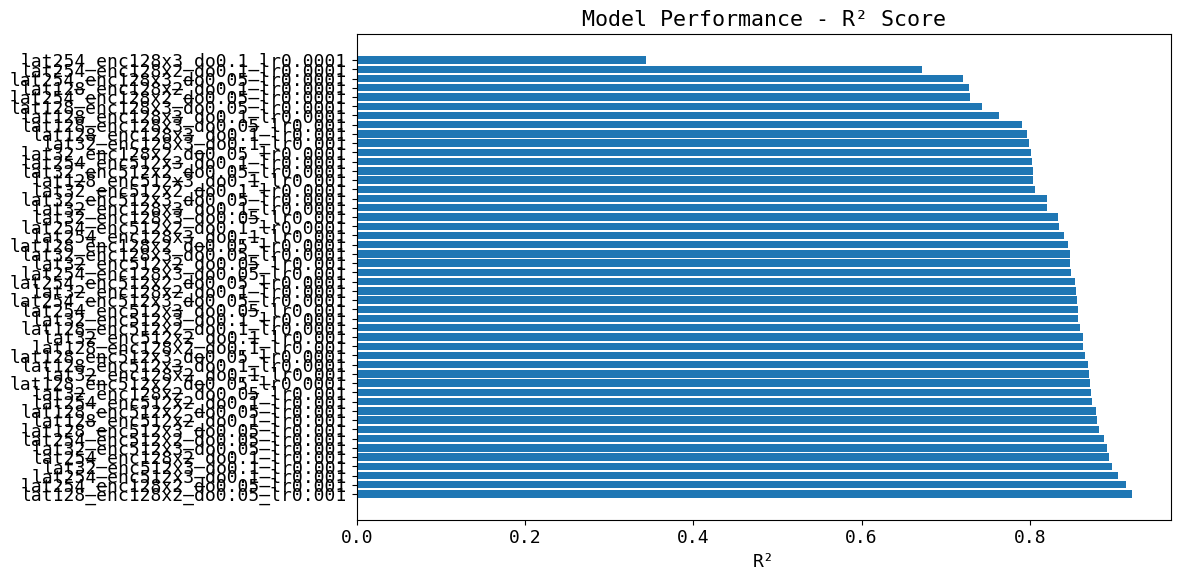

In [8]:
df_sorted = df.sort_values(by="R2", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["R2"])
plt.xlabel("R²")
plt.title("Model Performance - R² Score")
plt.tight_layout()
plt.show()


### Bar plot for MSE

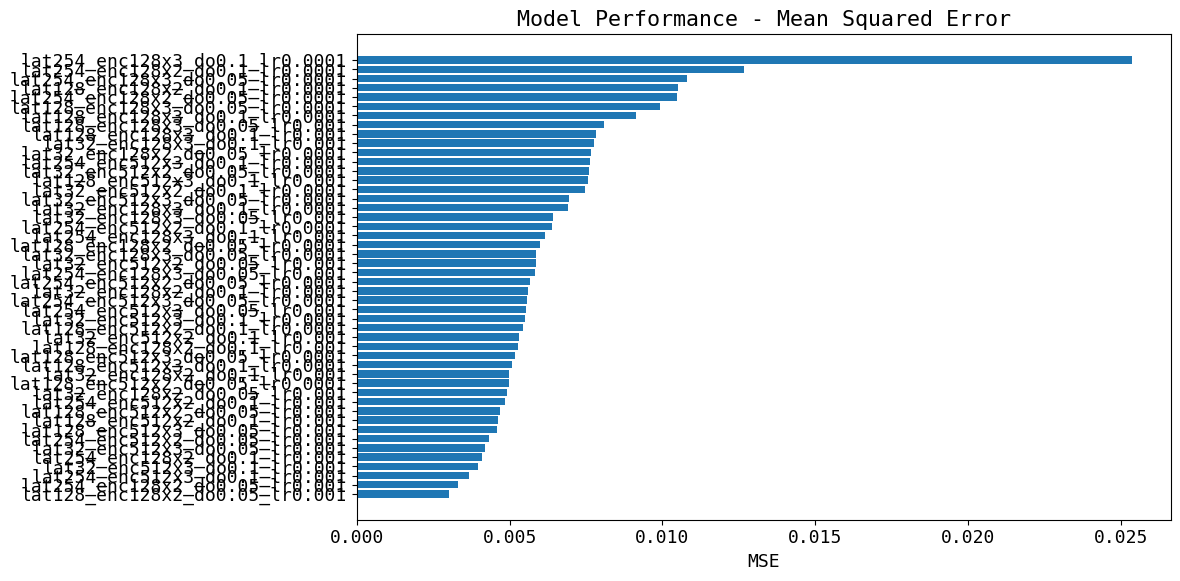

In [9]:
df_sorted = df.sort_values(by="MSE", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["MSE"])
plt.xlabel("MSE")
plt.title("Model Performance - Mean Squared Error")
plt.tight_layout()
plt.show()

### Bar plot for Pearson correlation

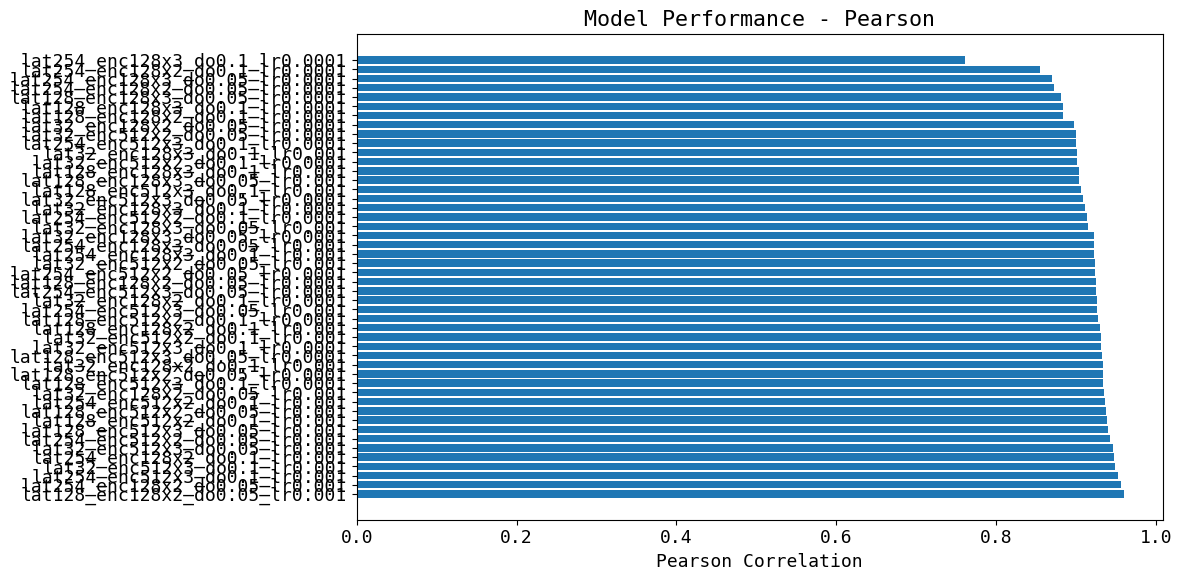

In [10]:
df_sorted = df.sort_values(by="Pearson", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["Pearson"])
plt.xlabel("Pearson Correlation")
plt.title("Model Performance - Pearson")
plt.tight_layout()
plt.show()

###  Bar plot for KDE divergence

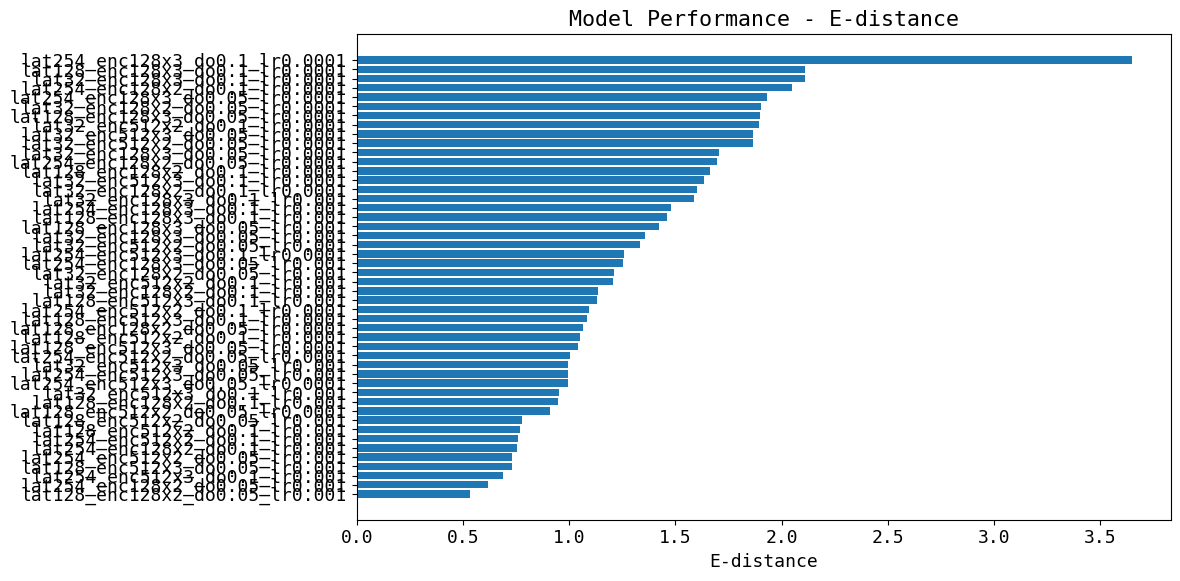

In [11]:
df_sorted = df.sort_values(by="e_distance", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["e_distance"])
plt.xlabel("E-distance")
plt.title("Model Performance - E-distance")
plt.tight_layout()
plt.show()

### Bar plot for Top-100 DEG Jaccard similarity

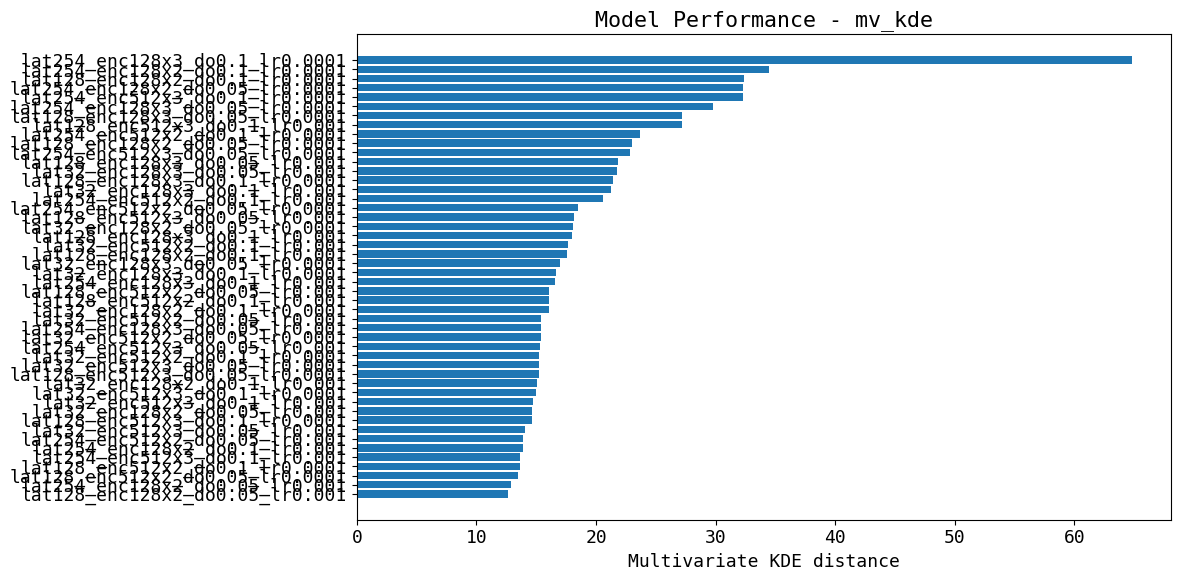

In [12]:
df_sorted = df.sort_values(by="mv_kde", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["mv_kde"])
plt.xlabel("Multivariate KDE distance")
plt.title("Model Performance - mv_kde")
plt.tight_layout()
plt.show()

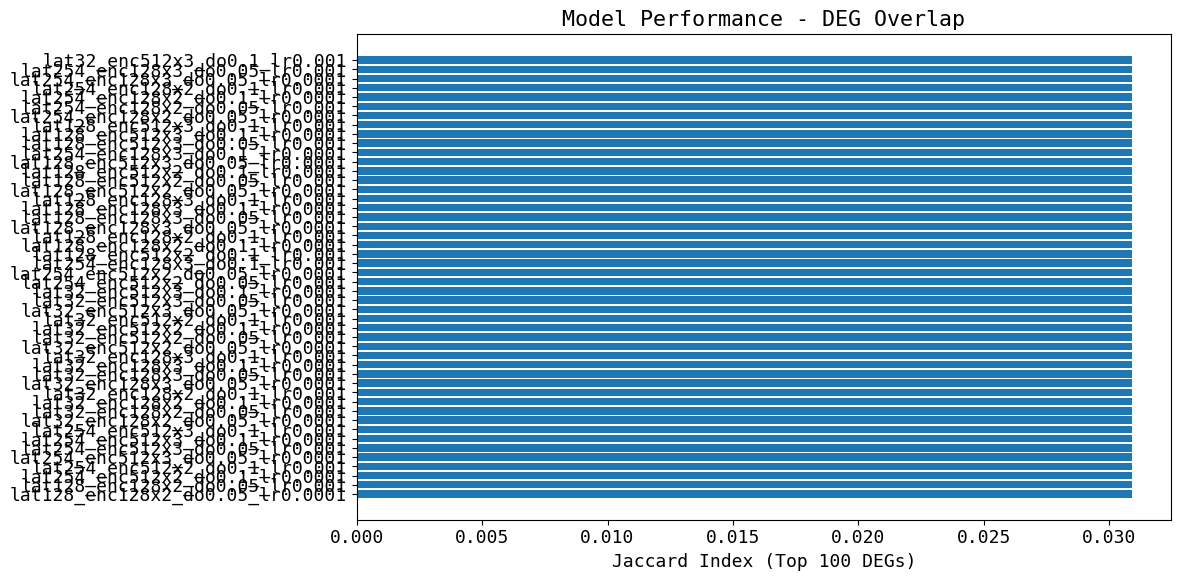

In [13]:
df_sorted = df.sort_values(by="jaccard_top100", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["jaccard_top100"])
plt.xlabel("Jaccard Index (Top 100 DEGs)")
plt.title("Model Performance - DEG Overlap")
plt.tight_layout()
plt.show()